### Metricas escolhidas
- Acurácia
    -como no artigo de referência
    -fácil de interpretar
- Precisão
    -evita falsos positivos (evitar risco pra quem nn tem problema de saúde mental)
- Recall (fundamental)
    -ver quais os positivos corretos, fundamental pois um falso negativo pode ser muito
    prejudicial, algm q tem problema e o modelo nn detectou
- F1-score
    -combinação de Recall e PrecisãO

In [2]:
"""!python.exe -m pip install --upgrade pip
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install plotly
!pip install shap
!pip install seaborn
!pip install missingno
!pip install Jinja2
!pip install catboost --quiet"""

'!python.exe -m pip install --upgrade pip\n!pip install pandas\n!pip install matplotlib\n!pip install scikit-learn\n!pip install plotly\n!pip install shap\n!pip install seaborn\n!pip install missingno\n!pip install Jinja2\n!pip install catboost --quiet'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
import numpy as np
import shap

In [4]:
url = "https://raw.githubusercontent.com/techtenant/OSMI-Mental-Health-in-Tech-Survey/master/mental-heath-in-tech-2016_20161114.csv"

dataset = pd.read_csv(url)

backup = pd.read_csv(url)

ignore_cat = ['Timestamp', 'comments']


Visualização das principais informações estruturais do dataset (colunas, tipos e valores nulos).

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

Renomeia as colunas do conjunto de dados para nomes mais descritivos e padronizados, facilitando a interpretação e o uso nas etapas seguintes da análise.

In [6]:
renamed_columns=["Self_employed","Total_employees","Tech_organization","IT_Tech","Mental_health_coverage","Awareness_of_options_under_coverage","Employers_discussion_on_mental_health","Resources_and_options_for_help","Anomity_of_employees_using_mental_health_resources","Mental_issue_related_leave","Discussing_mental_health_neg_consequences","Discussing_physical_health_neg_consequences","Comfort_discussing_with_coworkers","Comfort_discussing_with_supervisor","Employer_seriousness_on_mental_health","Negative_consequences_of_coworkers_with_mental_health_disorder","Medical_coverage","Aware_of_local_online_resources","Reveal_condition_to_clients_business_contacts","Consequence_if_revealed_health_issue_to_client_or_business_contact",'Diagnosed_but_not_revealed_with_coworkers_employees','negimpact_reveal_coworker','prod_affect_mental_issue','percent_worktime_affected','have_prev_empl','prev_empl_mental_benefits','aware_benefits_prev_empl','formal_discuss_mental_health_premp','premp_provide_resources_learn_seekhelp','anonymity_protect_premp_choose_resources','neg_eff_discuss_mental_health_premp','neg_eff_discuss_phy_health_premp','willing_discuss_issue_prev_coworkers','willing_discuss_issue_dir_supervisors','premp_took_menhealth_seriously_as_phyhealth','neg_comments_abt_coworkers_with_menissues_prev_workplace','bring_phyhealth_issue_with_potential_empl_interview','phy_y_ynot','bring_menhealth_issue_with_potential_empl_interview','men_y_ynot','hurt_carrer_if_identified_as_person_with_mental_issue','more_neg_view_from_coworker_if_know_abt_men_issue','share_w_friends_fam','workplace_response','other_exp_in_workplace','fam_hist','past_mh','curr_mh','diagnosed','maybe_diagnosed','diagnosed_prof','diagnosed_prof_mh','treatment_mh_prof','work_interference_treatment','work_interference_no_treatment','age','gender','country_live','us_state_live','country_work','us_state_work','work_pos','remote']
dataset.columns=renamed_columns

Transformando a variável alvo 'diagnosed_prof' em valores binários (0 e 1), onde 1 indica que o participante foi diagnosticado com um transtorno mental por um profissional de saúde.

In [7]:
dataset['diagnosed_prof'] = dataset['diagnosed_prof'].map({'Yes': 1, 'No': 0})

Identifica e remove as colunas que possuem mais de 50% de valores ausentes, mantendo apenas aquelas com quantidade suficiente de dados para análise.

In [8]:
to_drop_columns=[i for i in dataset.columns if dataset[i].isna().sum()>dataset.shape[0]/2]
print(to_drop_columns)
dataset.drop(to_drop_columns,axis=1,inplace=True)

['IT_Tech', 'Medical_coverage', 'Aware_of_local_online_resources', 'Reveal_condition_to_clients_business_contacts', 'Consequence_if_revealed_health_issue_to_client_or_business_contact', 'Diagnosed_but_not_revealed_with_coworkers_employees', 'negimpact_reveal_coworker', 'prod_affect_mental_issue', 'percent_worktime_affected', 'other_exp_in_workplace', 'diagnosed', 'maybe_diagnosed', 'diagnosed_prof_mh']


Remove colunas com respostas textuais (“phy_y_ynot” e “men_y_ynot”), pois contêm apenas comentários sem valor analítico.

In [9]:
dataset.drop(labels='phy_y_ynot', axis=1, inplace=True)
dataset.drop(labels='men_y_ynot', axis=1, inplace=True)

Substitui valores ausentes em colunas relacionadas ao emprego anterior por “Not Applicable”, uma vez que esses campos são irrelevantes para quem não teve experiências profissionais anteriores.

In [10]:
dataset.fillna({'prev_empl_mental_benefits': 'Not Applicable'}, inplace=True)
dataset.fillna({'aware_benefits_prev_empl': 'Not Applicable'}, inplace=True)
dataset.fillna({'formal_discuss_mental_health_premp': 'Not Applicable'}, inplace=True)
dataset.fillna({'premp_provide_resources_learn_seekhelp': 'Not Applicable'}, inplace=True)
dataset.fillna({'anonymity_protect_premp_choose_resources': 'Not Applicable'}, inplace=True)
dataset.fillna({'neg_eff_discuss_mental_health_premp': 'Not Applicable'}, inplace=True)
dataset.fillna({'neg_eff_discuss_phy_health_premp': 'Not Applicable'}, inplace=True)
dataset.fillna({'willing_discuss_issue_dir_supervisors': 'Not Applicable'}, inplace=True)
dataset.fillna({'willing_discuss_issue_prev_coworkers': 'Not Applicable'}, inplace=True)
dataset.fillna({'premp_took_menhealth_seriously_as_phyhealth': 'Not Applicable'}, inplace=True)
dataset.fillna({'neg_comments_abt_coworkers_with_menissues_prev_workplace': 'Not Applicable'}, inplace=True)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 48 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Self_employed                                                   1433 non-null   int64  
 1   Total_employees                                                 1146 non-null   object 
 2   Tech_organization                                               1146 non-null   float64
 3   Mental_health_coverage                                          1146 non-null   object 
 4   Awareness_of_options_under_coverage                             1013 non-null   object 
 5   Employers_discussion_on_mental_health                           1146 non-null   object 
 6   Resources_and_options_for_help                                  1146 non-null   object 
 7   Anomity_of_employees_using_mental_health_resources 

Exibe a contagem de respostas em cada categoria da variável “work_pos”, permitindo observar a distribuição dos cargos ou funções dos participantes.

In [12]:
dataset['work_pos'].value_counts()

work_pos
Back-end Developer                                                                                                                  263
Front-end Developer                                                                                                                 125
Other                                                                                                                               112
Supervisor/Team Lead                                                                                                                 68
Back-end Developer|Front-end Developer                                                                                               61
                                                                                                                                   ... 
One-person shop|Designer|Support                                                                                                      1
Supervisor/Team Lead|Support|One-person

Substitui valores ausentes na variável “gender” pelo valor mais frequente (moda), garantindo consistência e evitando perda de dados.

In [13]:
mode = dataset["gender"].mode()[0]
dataset["gender"] = dataset["gender"].fillna(mode)

Preenche os valores ausentes da variável “workplace_response” com a moda, preservando a consistência dos dados sem remover registros.

In [14]:
mode = dataset["workplace_response"].mode()[0]
dataset["workplace_response"] = dataset["workplace_response"].fillna(mode)

Substitui valores ausentes na variável “Negative_consequences_of_coworkers_with_mental_health_disorder” pelo valor mais frequente, mantendo a consistência dos dados.

In [15]:
mode = dataset["Negative_consequences_of_coworkers_with_mental_health_disorder"].mode()[0]
dataset["Negative_consequences_of_coworkers_with_mental_health_disorder"] = dataset["Negative_consequences_of_coworkers_with_mental_health_disorder"].fillna(mode)

Preenche os valores ausentes da variável “Employer_seriousness_on_mental_health” com a moda, garantindo consistência e completude nos dados.

In [16]:
mode = dataset["Employer_seriousness_on_mental_health"].mode()[0]
dataset["Employer_seriousness_on_mental_health"] = dataset["Employer_seriousness_on_mental_health"].fillna(mode)

Substitui os valores ausentes da variável “Comfort_discussing_with_supervisor” pelo valor mais frequente, mantendo a consistência do dataset.

In [17]:
mode = dataset["Comfort_discussing_with_supervisor"].mode()[0]
dataset["Comfort_discussing_with_supervisor"] = dataset["Comfort_discussing_with_supervisor"].fillna(mode)

Preenche os valores ausentes da variável “Comfort_discussing_with_coworkers” com o valor mais frequente, garantindo completude e consistência nos dados.

In [18]:
mode = dataset["Comfort_discussing_with_coworkers"].mode()[0]
dataset["Comfort_discussing_with_coworkers"] = dataset["Comfort_discussing_with_coworkers"].fillna(mode)

Substitui valores ausentes da variável “Discussing_mental_health_neg_consequences” pelo valor mais frequente, mantendo a consistência e completude do dataset.

In [19]:
mode = dataset["Discussing_mental_health_neg_consequences"].mode()[0]
dataset["Discussing_mental_health_neg_consequences"] = dataset["Discussing_mental_health_neg_consequences"].fillna(mode)

Substitui valores ausentes da variável “Discussing_physical_health_neg_consequences” pelo valor mais frequente, mantendo a consistência e completude do dataset.

In [20]:
mode = dataset["Discussing_physical_health_neg_consequences"].mode()[0]
dataset["Discussing_physical_health_neg_consequences"] = dataset["Discussing_physical_health_neg_consequences"].fillna(mode)

Preenche os valores ausentes da variável “Mental_issue_related_leave” com o valor mais frequente, garantindo consistência nos dados.

In [21]:
mode = dataset["Mental_issue_related_leave"].mode()[0]
dataset["Mental_issue_related_leave"] = dataset["Mental_issue_related_leave"].fillna(mode)

Substitui valores ausentes da variável “Anomity_of_employees_using_mental_health_resources” pelo valor mais frequente, mantendo a consistência do dataset.

In [22]:
mode = dataset["Anomity_of_employees_using_mental_health_resources"].mode()[0]
dataset["Anomity_of_employees_using_mental_health_resources"] = dataset["Anomity_of_employees_using_mental_health_resources"].fillna(mode)

Preenche os valores ausentes da variável “Resources_and_options_for_help” com o valor mais frequente, garantindo consistência e completude nos dados.

In [23]:
mode = dataset["Resources_and_options_for_help"].mode()[0]
dataset["Resources_and_options_for_help"] = dataset["Resources_and_options_for_help"].fillna(mode)

Substitui os valores ausentes da variável “Employers_discussion_on_mental_health” pelo valor mais frequente, mantendo a consistência do dataset.

In [24]:
mode = dataset["Employers_discussion_on_mental_health"].mode()[0]
dataset["Employers_discussion_on_mental_health"] = dataset["Employers_discussion_on_mental_health"].fillna(mode)

Preenche os valores ausentes da variável “Awareness_of_options_under_coverage” com o valor mais frequente, garantindo consistência e completude nos dados.

In [25]:
mode = dataset["Awareness_of_options_under_coverage"].mode()[0]
dataset["Awareness_of_options_under_coverage"] = dataset["Awareness_of_options_under_coverage"].fillna(mode)

Substitui os valores ausentes da variável “Mental_health_coverage” pelo valor mais frequente, mantendo a consistência do dataset.

In [26]:
mode = dataset["Mental_health_coverage"].mode()[0]
dataset["Mental_health_coverage"] = dataset["Mental_health_coverage"].fillna(mode)

Preenche os valores ausentes da variável “Total_employees” com o valor mais frequente, garantindo completude e consistência nos dados.

In [27]:
mode = dataset["Total_employees"].mode()[0]
dataset["Total_employees"] = dataset["Total_employees"].fillna(mode)

Substitui valores ausentes da variável “Tech_organization” pelo valor mais frequente, mantendo a consistência do dataset.

In [28]:
mode = dataset["Tech_organization"].mode()[0]
dataset["Tech_organization"] = dataset["Tech_organization"].fillna(mode)


Preenche os valores ausentes da variável “us_state_live” com “NO APPLIED”, indicando que o participante não se aplica a nenhum estado específico.

In [29]:
dataset["us_state_live"] = dataset['us_state_live'].fillna("NO APPLIED")

Preenche os valores ausentes da variável “us_state_work” com “NO APPLIED”, indicando que o participante não se aplica a nenhum estado de trabalho específico.

In [30]:
dataset["us_state_work"] = dataset['us_state_work'].fillna("NO APPLIED")

Preenche os valores ausentes da variável “Self_employed” com o valor mais frequente, garantindo consistência e completude nos dados.

In [31]:
mode = dataset["Self_employed"].mode()[0]
dataset["Self_employed"] = dataset["Self_employed"].fillna(mode)

Substitui os valores ausentes da variável “work_interference_treatment” pelo valor mais frequente, garantindo consistência nos dados.

In [32]:
mode = dataset["work_interference_treatment"].mode()[0]
dataset["work_interference_treatment"] = dataset["work_interference_treatment"].fillna(mode)

Substitui idades inválidas ou extremas (menores que 18 ou maiores que 75) pela média das idades válidas, garantindo coerência nos dados.

In [33]:
mean_age = dataset[(dataset['age'] >= 18) & (dataset['age'] <= 80)]['age'].mean()
mask = (dataset['age'] < 18) | (dataset['age'] > 75)
dataset.loc[mask, 'age'] = mean_age


C:\Users\estev\AppData\Local\Temp\ipykernel_15960\2003322738.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.08613445378151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[mask, 'age'] = mean_age


Exibe a contagem de cada categoria da variável “gender” após o preenchimento dos valores ausentes, permitindo verificar a distribuição dos participantes por gênero.

In [34]:
dataset["gender"].value_counts()

gender
Male                                       613
male                                       249
Female                                     153
female                                      95
M                                           86
                                          ... 
female-bodied; no feelings about gender      1
cis man                                      1
AFAB                                         1
Transgender woman                            1
MALE                                         1
Name: count, Length: 70, dtype: int64

Padroniza a variável “gender”: converte todos os valores para minúsculas, remove espaços extras e agrupa respostas equivalentes em três categorias principais — “Female”, “Male” e “Other”.

In [35]:
genders = dataset['gender'].str.lower().str.strip()

female_terms = ['female', 'f ', 'f$', 'woman', 'cis female', 'femake', 'femail', 'trans-female']
male_terms = ['male', 'm ', 'm$', 'man', 'cis male', 'cis man', 'mal', 'maile', 'make']

dataset['gender'] = np.where(
    genders.str.contains('|'.join(female_terms), na=False, regex=True), 'Female',
    np.where(
        genders.str.contains('|'.join(male_terms), na=False, regex=True), 'Male',
        'Other'
    )
)

Exibe a contagem de participantes por idade, permitindo verificar a distribuição após a substituição de valores extremos ou inválidos.

In [36]:
dataset['age'].value_counts()

age
30.000000    94
31.000000    82
29.000000    79
35.000000    74
28.000000    74
32.000000    72
34.000000    69
33.000000    69
26.000000    64
27.000000    63
37.000000    59
39.000000    55
38.000000    54
36.000000    50
25.000000    44
24.000000    42
40.000000    36
22.000000    32
44.000000    31
43.000000    30
42.000000    29
45.000000    27
41.000000    24
23.000000    24
46.000000    22
21.000000    15
47.000000    14
49.000000    13
55.000000    12
48.000000     9
50.000000     9
52.000000     7
51.000000     7
54.000000     7
20.000000     6
56.000000     5
34.086134     5
19.000000     4
57.000000     4
63.000000     4
53.000000     3
61.000000     2
59.000000     2
58.000000     1
62.000000     1
66.000000     1
65.000000     1
74.000000     1
70.000000     1
Name: count, dtype: int64

### Histograma

Cria gráficos de barras para todas as colunas do dataset (numéricas e categóricas), mostrando a distribuição de valores em cada variável. Para variáveis categóricas, são exibidas apenas as 10 categorias mais frequentes, facilitando a visualização.

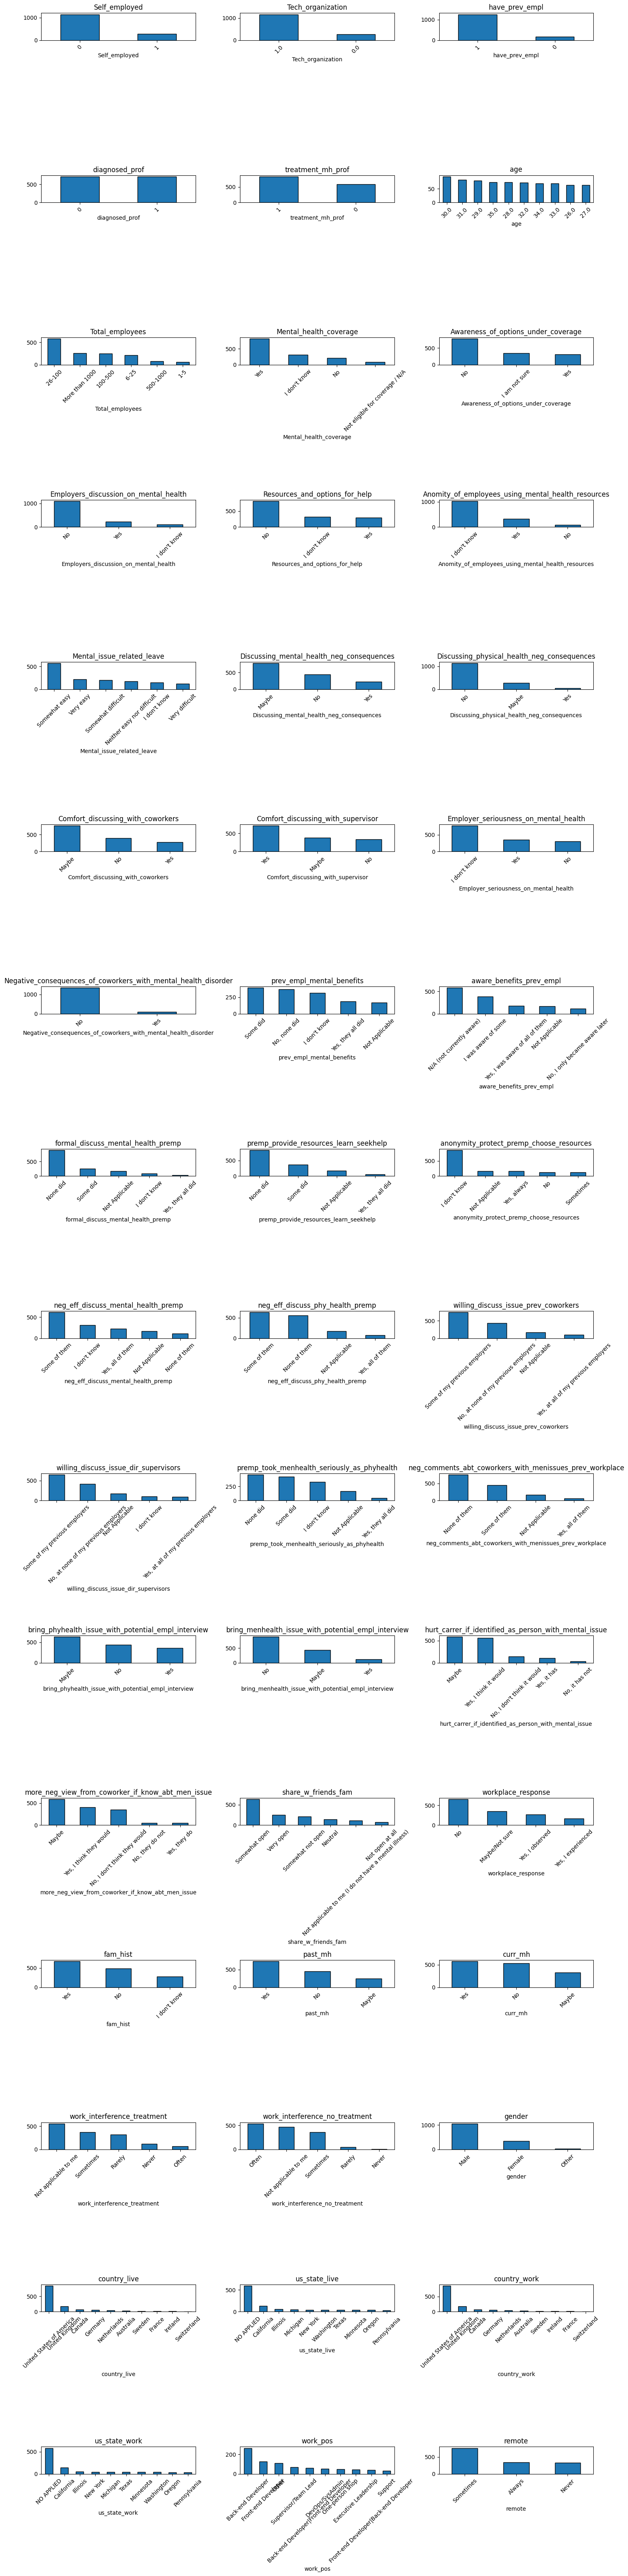

In [37]:
num_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [col for col in dataset.select_dtypes(exclude=['int64', 'float64']).columns if col not in ignore_cat]

all_cols = list(num_cols) + cat_cols

cols_per_row = 3
rows = math.ceil(len(all_cols)/cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*5, rows*4))
axes = axes.flatten()

idx = 0

for col in all_cols:
    try:
        counts = dataset[col].value_counts(dropna=True)
        counts = counts.nlargest(10) if counts.dtype != 'O' else counts.head(10)
        counts.plot(kind='bar', ax=axes[idx], edgecolor='black')
        axes[idx].set_title(col)
        axes[idx].tick_params(axis='x', rotation=45)
        idx += 1
    except Exception as e:
        print(f"Skipping {col} due to error: {e}")

for j in range(idx, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## CatBoost

Antes de tratar as colunas categóricas para os modelos seguintes, foi treinado o **CatBoost**, que aceita variáveis categóricas diretamente.  
O CatBoost realiza internamente uma codificação baseada no target, permitindo treinar o modelo sem pré-processamento manual das colunas categóricas.


In [38]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

y = dataset['diagnosed_prof']
X = dataset.drop(columns=['diagnosed_prof'], axis=1)

from sklearn.model_selection import train_test_split

X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

categorical_cols = ["Mental_health_coverage",
                     "Awareness_of_options_under_coverage",
                       "Employers_discussion_on_mental_health",
                        "fam_hist",
                        "past_mh",
                        "curr_mh",
                        "remote",
                        "Discussing_physical_health_neg_consequences",
                        "Comfort_discussing_with_coworkers",
                         'Resources_and_options_for_help',
                         "Anomity_of_employees_using_mental_health_resources",
                         "Discussing_mental_health_neg_consequences",
                         "Comfort_discussing_with_supervisor",
                         "Employer_seriousness_on_mental_health",
                         "Negative_consequences_of_coworkers_with_mental_health_disorder",
                         "prev_empl_mental_benefits",
                         "aware_benefits_prev_empl",
                         "formal_discuss_mental_health_premp",
                         "premp_provide_resources_learn_seekhelp",
                         "anonymity_protect_premp_choose_resources",
                         "neg_eff_discuss_mental_health_premp",
                         "neg_eff_discuss_phy_health_premp",
                         "willing_discuss_issue_prev_coworkers",
                         "willing_discuss_issue_dir_supervisors",
                         "premp_took_menhealth_seriously_as_phyhealth",
                         "neg_comments_abt_coworkers_with_menissues_prev_workplace",
                         "bring_phyhealth_issue_with_potential_empl_interview",
                         "bring_menhealth_issue_with_potential_empl_interview",
                         "share_w_friends_fam", "work_interference_treatment",
                         "work_interference_no_treatment",
                         "gender",
                         "country_live",
                         "us_state_live",
                         "country_work",
                         "us_state_work",
                         "work_pos",
                         "Total_employees",
                         "Mental_issue_related_leave",
                         "hurt_carrer_if_identified_as_person_with_mental_issue",
                         "more_neg_view_from_coworker_if_know_abt_men_issue",
                         "workplace_response"
                        ]

cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6, learning_rate=0.1, l2_leaf_reg=3,
    iterations=2000, random_state=42,
    verbose=False
)

cat_model.fit(X_train_full, y_train_full, cat_features=categorical_cols)

y_final_pred = cat_model.predict(X_holdout)
print("Acurácia final no hold-out:", accuracy_score(y_holdout, y_final_pred))

Acurácia final no hold-out: 0.9024390243902439


Calculo e plotagem da matriz de confusão do modelo CatBoost no conjunto hold-out, mostrando quantas amostras de cada classe foram corretamente ou incorretamente classificadas de forma visual com um heatmap.

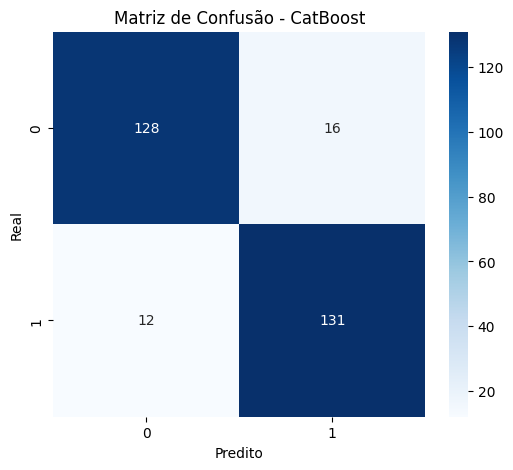

Relatório de Classificação:

              precision    recall  f1-score   support

           0     0.9143    0.8889    0.9014       144
           1     0.8912    0.9161    0.9034       143

    accuracy                         0.9024       287
   macro avg     0.9027    0.9025    0.9024       287
weighted avg     0.9028    0.9024    0.9024       287



In [39]:
from sklearn.metrics import confusion_matrix, classification_report

y_final_pred = cat_model.predict(X_holdout)

cm = confusion_matrix(y_holdout, y_final_pred, labels=cat_model.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_model.classes_,
            yticklabels=cat_model.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - CatBoost')
plt.show()
class_names = [str(c) for c in cat_model.classes_]
report = classification_report(y_holdout, y_final_pred, target_names=class_names, digits=4)
print("Relatório de Classificação:\n")
print(report)



Gera a curva ROC do modelo CatBoost usando o conjunto hold-out, mostrando a relação entre a taxa de falsos positivos e a taxa de verdadeiros positivos, e calcula a AUC (área sob a curva) para medir a performance de classificação do modelo.

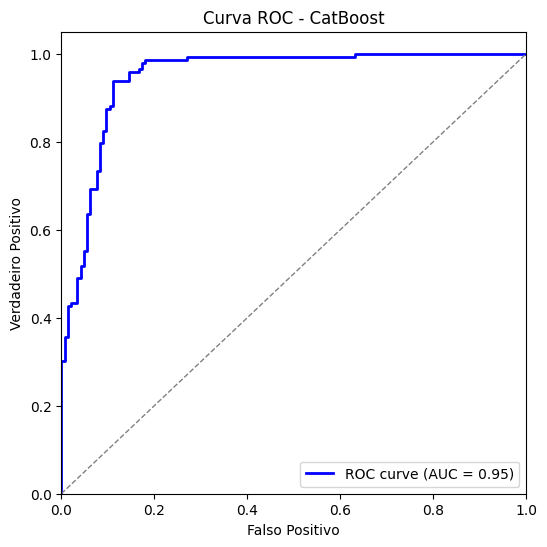

In [40]:
from sklearn.metrics import roc_curve, auc

y_probs = cat_model.predict_proba(X_holdout)[:, 1]

fpr, tpr, thresholds = roc_curve(y_holdout, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - CatBoost')
plt.legend(loc="lower right")
plt.show()


Cálculo e plotagem da importância das features do modelo CatBoost, mostrando apenas as top 20 mais relevantes, para facilitar a visualização das variáveis que mais influenciam as previsões do modelo.

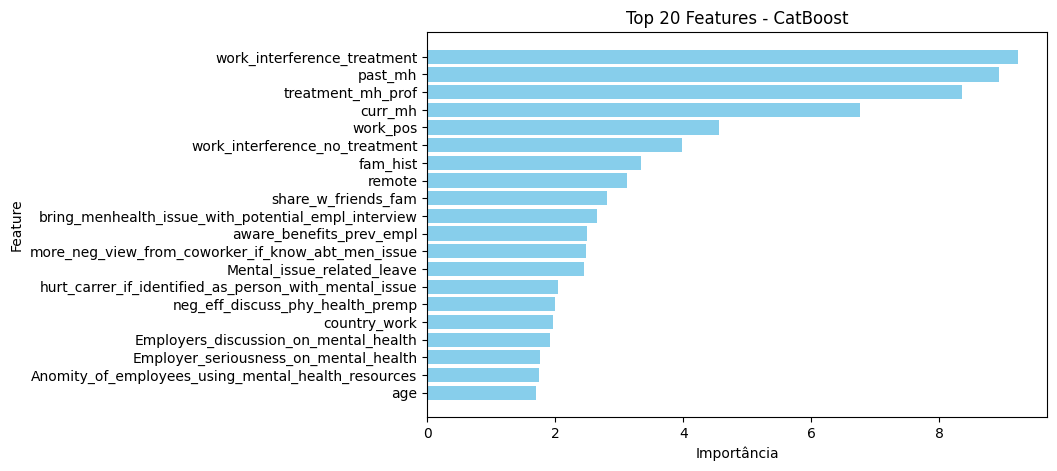

In [41]:
from catboost import Pool

train_pool = Pool(X_train_full, y_train_full, cat_features=categorical_cols)

feature_importances = cat_model.get_feature_importance(train_pool)
feature_names = X_train_full.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

top_n = 20
fi_df_top = fi_df.head(top_n)

plt.figure(figsize=(8,5))
plt.barh(fi_df_top['Feature'], fi_df_top['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features - CatBoost')
plt.show()


A próxima célula gera e plota um resumo do SHAP para o modelo CatBoost, mostrando a contribuição de cada feature para as previsões no conjunto de hold-out, facilitando a interpretação do impacto das variáveis.

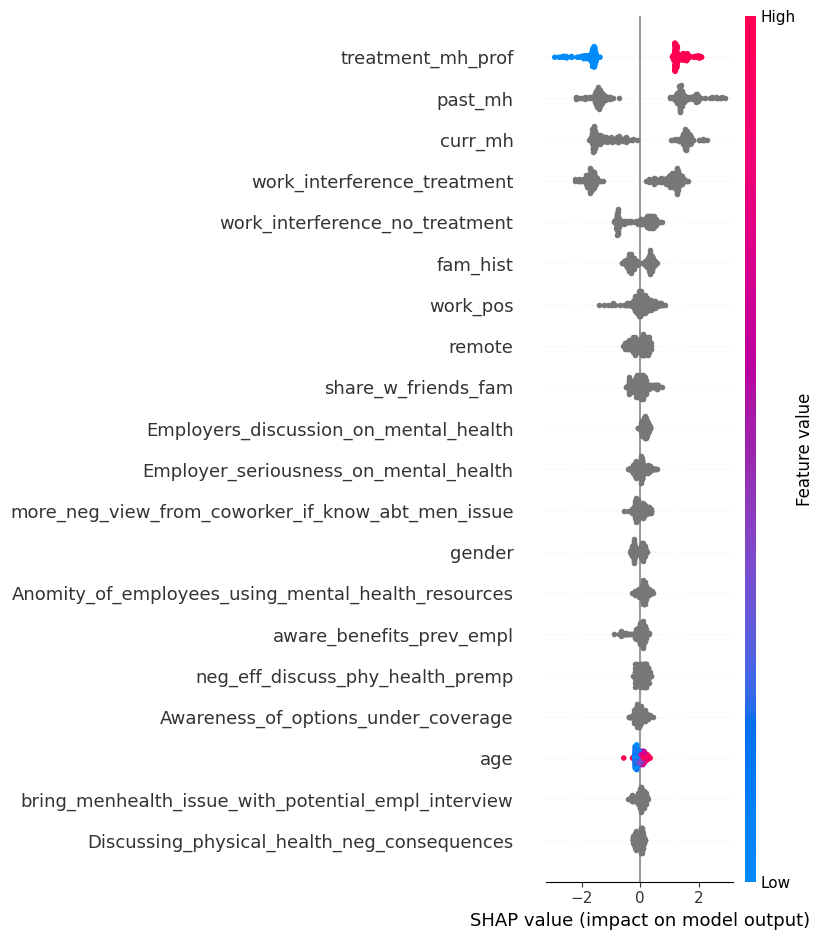

In [42]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_holdout)

shap.summary_plot(shap_values, X_holdout)


### Aplicando Ordinal Encoder

Aplica codificação ordinal em variáveis categóricas com hierarquia ou ordem implícita. Cada variável recebe uma ordem específica definida previamente, permitindo que valores categóricos sejam convertidos em números.

In [43]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

cat_workplace_response = [
    "No",
    "Maybe/Not sure",
    "Yes, I observed",
    "Yes, I experienced"
]

cat_more_neg_view_from_coworker_if_know_abt_men_issue = [
    "No, they do not",
    "No, I don't think they would ",
    "Yes, I think they would",
    "Yes, they do",
    "Maybe"
]


cat_yes_or_no = [
    'No',
    'Yes'
]

cat_mental_issue_related_leave = [
    "i don't know",
    'Somwhat easy',
    'Very easy',
    'Neiter easy nor difficult',
    'Somwhat dificult',
    'Very difficult',
]

cat_if_identified_as_person_with_mental_issue = [
    'No, it has not',
    "No, I don't think it would"
    'Maybe',
    'Yes, I think it would',
    "Yes, it has"
]

cat_no_employer = [
    "1-5",
    "6-25",
    "26-100"
    "100-500",
    "500-1000",
    "more than 1000"
]

cat_workplace_response = [
    'No',
    "Maybe/Not sure",
    "Yes, I observed",
    "Yes, I experienced"
]

# Lista de variáveis a serem codificadas de forma ordinal
cat_list_ordinal = ["Total_employees", "Mental_issue_related_leave", "hurt_carrer_if_identified_as_person_with_mental_issue", "more_neg_view_from_coworker_if_know_abt_men_issue","workplace_response",]

for cat in cat_list_ordinal:
    dataset_cat = dataset[[cat]]
    try:
        encoder =  OrdinalEncoder(categories=[cat_yes_or_no])
        if cat == "Total_employees":
            encoder = OrdinalEncoder(categories=[cat_no_employer])
        elif cat == "hurt_carrer_if_identified_as_person_with_mental_issue":
            encoder = OrdinalEncoder(categories=[cat_if_identified_as_person_with_mental_issue])
        elif cat == "Mental_issue_related_leave":
            encoder = OrdinalEncoder(categories=[cat_mental_issue_related_leave])
        elif cat == "more_neg_view_from_coworker_if_know_abt_men_issue":
            encoder = OrdinalEncoder(categories=[cat_more_neg_view_from_coworker_if_know_abt_men_issue])
        elif cat == "workplace_response":
            encoder = OrdinalEncoder(categories=[cat_workplace_response])
        dataset[cat] = encoder.fit_transform(dataset_cat)
    except:
        dataset[cat] = ordinal_encoder.fit_transform(dataset_cat)

### Aplicando OneHotEncoder

Aplica codificação one-hot nas variáveis categóricas nominais, transformando cada categoria em uma coluna binária. Isso permite que algoritmos de aprendizado de máquina lidem com variáveis categóricas sem assumir ordem entre os valores.

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

cat_list_one_hot = ["Mental_health_coverage",
                     "Awareness_of_options_under_coverage",
                       "Employers_discussion_on_mental_health",
                       "fam_hist",
                       "past_mh",
                       "curr_mh",
                       "remote",
                       "Discussing_physical_health_neg_consequences",
                        "Comfort_discussing_with_coworkers",
                         'Resources_and_options_for_help',
                         "Anomity_of_employees_using_mental_health_resources",
                         "Discussing_mental_health_neg_consequences",
                         "Comfort_discussing_with_supervisor",
                         "Employer_seriousness_on_mental_health",
                         "Negative_consequences_of_coworkers_with_mental_health_disorder",
                         "prev_empl_mental_benefits",
                         "aware_benefits_prev_empl",
                         "formal_discuss_mental_health_premp",
                         "premp_provide_resources_learn_seekhelp",
                         "anonymity_protect_premp_choose_resources",
                         "neg_eff_discuss_mental_health_premp",
                         "neg_eff_discuss_phy_health_premp",
                         "willing_discuss_issue_prev_coworkers",
                         "willing_discuss_issue_dir_supervisors",
                         "premp_took_menhealth_seriously_as_phyhealth",
                         "neg_comments_abt_coworkers_with_menissues_prev_workplace",
                         "bring_phyhealth_issue_with_potential_empl_interview",
                         "bring_menhealth_issue_with_potential_empl_interview",
                        "share_w_friends_fam",
                        "work_interference_treatment",
                        "work_interference_no_treatment",
                        "gender",
                        "country_live",
                        "us_state_live",
                        "country_work",
                        "us_state_work",
                        "work_pos"
                         ]

dt_cat = dataset[cat_list_one_hot]
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded_array = cat_encoder.fit_transform(dt_cat)

cat_encoded_df = pd.DataFrame(cat_encoded_array, columns=cat_encoder.get_feature_names_out(cat_list_one_hot))

df_clean = dataset.drop(columns=cat_list_one_hot)

dataset = pd.concat([df_clean, cat_encoded_df], axis=1)

Verifica os tipos de dados das colunas do dataset após as transformações, garantindo que todas as variáveis estejam no formato adequado para análise ou modelagem.

In [45]:
dataset.dtypes

Self_employed                                                                               int64
Total_employees                                                                           float64
Tech_organization                                                                         float64
Mental_issue_related_leave                                                                float64
have_prev_empl                                                                              int64
                                                                                           ...   
work_pos_Support|Front-end Developer|Designer                                             float64
work_pos_Support|HR|Supervisor/Team Lead|Executive Leadership                             float64
work_pos_Support|Other                                                                    float64
work_pos_Support|Sales|Back-end Developer|Front-end Developer|Designer|One-person shop    float64
work_pos_Support|Sal

Dividindo a base utilizando K-folds

Define a variável alvo “diagnosed_prof” como y e todas as demais colunas como X, preparando os dados para treinamento de modelos de aprendizado de máquina.

In [46]:
y = dataset['diagnosed_prof']
X = dataset.drop(columns=['diagnosed_prof'], axis=1)

Exibe os tipos de dados das variáveis preditoras (X) após a preparação do dataset, garantindo que todas estejam no formato adequado para modelagem.

In [47]:
X.dtypes

Self_employed                                                                               int64
Total_employees                                                                           float64
Tech_organization                                                                         float64
Mental_issue_related_leave                                                                float64
have_prev_empl                                                                              int64
                                                                                           ...   
work_pos_Support|Front-end Developer|Designer                                             float64
work_pos_Support|HR|Supervisor/Team Lead|Executive Leadership                             float64
work_pos_Support|Other                                                                    float64
work_pos_Support|Sales|Back-end Developer|Front-end Developer|Designer|One-person shop    float64
work_pos_Support|Sal

Lista as colunas de X que ainda possuem tipo object, permitindo verificar se restam variáveis categóricas que precisam de codificação adicional.

In [48]:
X.select_dtypes(include='object').columns


Index([], dtype='object')

Divide os dados em conjuntos de treinamento (X_train_full, y_train_full) e holdout (X_holdout, y_holdout) usando 20% dos dados para teste. A divisão é estratificada para manter a proporção das classes da variável alvo.

In [49]:
from sklearn.model_selection import train_test_split

X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Nota sobre o pré processamento

O pré-processamento aplicado neste estudo difere da abordagem base-line, que consistia em ajustes manuais dos dados.
Aqui, foram utilizadas técnicas de codificação ordinal e one-hot encoding, permitindo transformar variáveis categóricas em formato numérico. Essas transformações preservam as informações mais relevantes e preparam os dados para análise e modelagem de forma consistente.

# Avaliação de Modelos de Classificação: Baseline e árvore de Decisão

## Baseline Simples: Classe Majoritária

Antes de treinar qualquer modelo complexo, é importante definir um baseline mínimo de comparação.
Neste caso, utilizamos um classificador Dummy que sempre prevê a classe mais frequente do conjunto de treino.

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_full, y_train_full)
y_dummy_pred = dummy.predict(X_holdout)

print("Baseline (classe majoritária):", accuracy_score(y_holdout, y_dummy_pred))


Baseline (classe majoritária): 0.5017421602787456


O baseline alcançou uma acurácia de aproximadamente 50%, indicando que metade das amostras pertence à classe majoritária.
Qualquer modelo que supere esse valor já está capturando algum padrão relevante nos dados.

#Árvore de Decisão

Após definir o baseline simples, treinamos um modelo de referência usando uma Árvore de Decisão.
A escolha desse modelo como ponto de partida se deve ao fato de ser simples, mas já capaz de capturar relações não-lineares entre os atributos, servindo como referência inicial para comparação com modelos mais sofisticados, como Random Forest, Gradient Boosting.




## Validação Cruzada Estratificada (5 folds)

Aqui avaliamos a Árvore de Decisão via validação cruzada estratificada com 5 folds. Em cada fold o modelo é treinado em 4/5 dos dados de treino e validado no 1/5 restante; calculamos a acurácia de cada fold e reportamos a média. Este procedimento fornece uma estimativa robusta do desempenho do modelo antes do treinamento final.


In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

params = {
    'criterion': 'entropy',
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'random_state': 42
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in skf.split(X_train_full, y_train_full):
    X_train_full_full, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train_full_full, y_train)

    y_pred = clf.predict(X_val)
    scores.append(accuracy_score(y_val, y_pred))

print("Acurácia média no treino k-fold:", np.mean(scores).round(4))


Acurácia média no treino k-fold: 0.8796


A acurácia média obtida foi de aproximadamente 87,9%, indicando que o modelo baseline já apresenta bom desempenho.



## Treinamento Final e Avaliação no Conjunto Hold-Out

Em seguida, treinamos a árvore de decisão em todo o conjunto de treino e avaliamos no conjunto de teste hold-out.

In [52]:
dt = DecisionTreeClassifier(**params)
dt.fit(X_train_full, y_train_full)
y_final_pred = dt.predict(X_holdout)
print("Acurácia final no hold-out:", accuracy_score(y_holdout, y_final_pred))

Acurácia final no hold-out: 0.8606271777003485


No conjunto hold-out, o modelo alcançou 86,0% de acurácia, um resultado bastante próximo ao obtido na validação cruzada, o que reforça sua boa capacidade de generalização para dados inéditos.

## Curva ROC e AUC

O gráfico da Curva ROC mostra a capacidade do modelo de distinguir entre as classes.  
- O eixo **x** representa a taxa de falsos positivos (FPR = 1 - especificidade).  
- O eixo **y** representa a taxa de verdadeiros positivos (TPR = sensibilidade).  

A **AUC (Área Sob a Curva)** resume o desempenho global do modelo.  
- Valores próximos de 1 indicam excelente poder de separação entre as classes.  
- No nosso caso, AUC = 0.88 indica que a árvore de decisão tem bom desempenho.  

Essa análise é útil porque avalia o modelo de forma geral, independentemente do limiar de decisão.

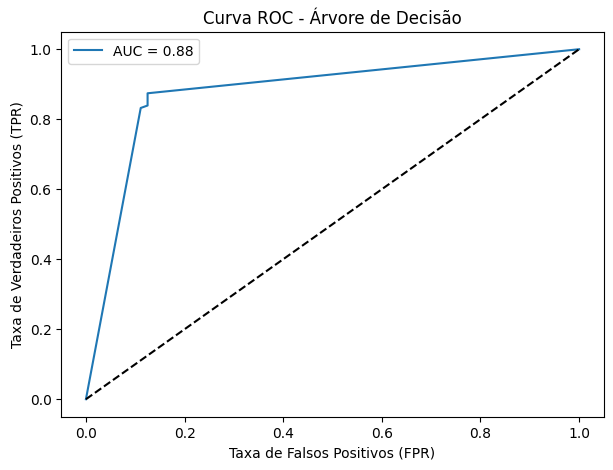

In [53]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

y_proba = dt.predict_proba(X_holdout)
classes = np.unique(y_holdout)

plt.figure(figsize=(7,5))

# Caso binário
if len(classes) == 2:
    fpr, tpr, _ = roc_curve(y_holdout, y_proba[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

# Caso multiclasse
else:
    y_holdout_bin = label_binarize(y_holdout, classes=classes)
    for i, classe in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_holdout_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{classe} (AUC = {roc_auc:.2f})")

# Gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC - Árvore de Decisão")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend()
plt.show()


A curva ROC da Árvore de Decisão mostra uma **forte separação entre classes**, com uma área sob a curva (AUC) de **0,88**.
Isso significa que, ao escolher aleatoriamente um caso positivo e um negativo, o modelo tem 88% de chance de classificar corretamente o positivo com uma probabilidade maior.

O formato da curva, que se aproxima do canto superior esquerdo, indica **baixo número de falsos positivos** e **alta taxa de verdadeiros positivos**, o que é desejável para este tipo de problema.

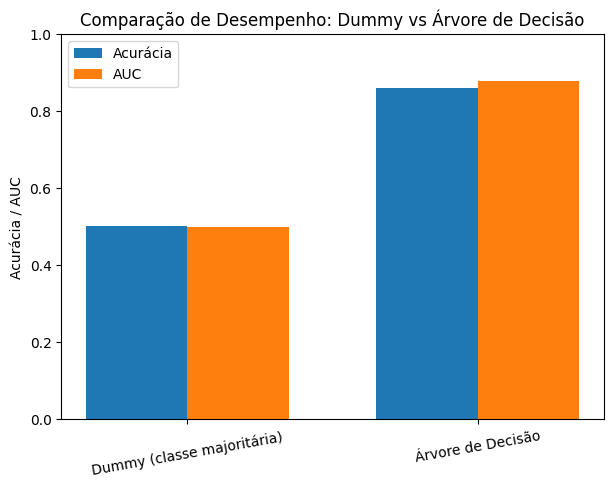

In [54]:
modelos = ['Dummy (classe majoritária)', 'Árvore de Decisão']
acuracias = [accuracy_score(y_holdout, y_dummy_pred), accuracy_score(y_holdout, y_final_pred)]
auc_scores = [0.5, roc_auc]  # Dummy tem AUC = 0.5 (modelo aleatório)

x = np.arange(len(modelos))
largura = 0.35

fig, ax = plt.subplots(figsize=(7,5))
b1 = ax.bar(x - largura/2, acuracias, largura, label='Acurácia')
b2 = ax.bar(x + largura/2, auc_scores, largura, label='AUC')

ax.set_title('Comparação de Desempenho: Dummy vs Árvore de Decisão')
ax.set_ylabel('Acurácia / AUC')
ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=10)
ax.legend()
plt.show()


## Comparativo de Desempenho

O gráfico mostra claramente que o modelo de Árvore de Decisão supera o baseline simples:
- Acurácia aumenta de **50% para 86,0%**.
- AUC cresce de **0,50 (aleatório)** para **0,88**, indicando boa capacidade discriminatória.

Essa comparação reforça que o modelo de árvore está capturando padrões relevantes nos dados, indo muito além da simples frequência da classe majoritária.


## Matriz de Confusão e Relatório de Classificação

A matriz de confusão mostra a contagem de previsões corretas e incorretas para cada classe, permitindo identificar possíveis erros sistemáticos.
O relatório de classificação apresenta métricas detalhadas por classe, incluindo precision, recall e F1-score, além da acurácia global.


Relatório de Classificação:
               precision    recall  f1-score
0              0.842105  0.888889  0.864865
1              0.881481  0.832168  0.856115
accuracy       0.860627  0.860627  0.860627
macro avg      0.861793  0.860528  0.860490
weighted avg   0.861725  0.860627  0.860505


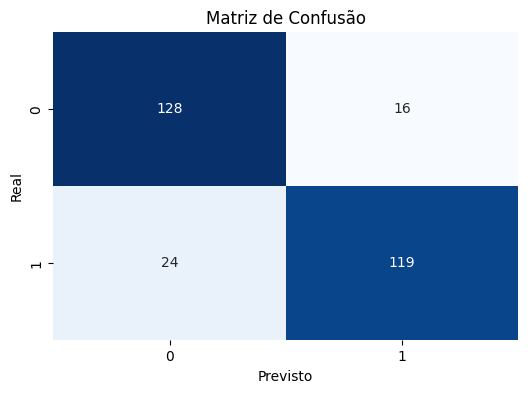

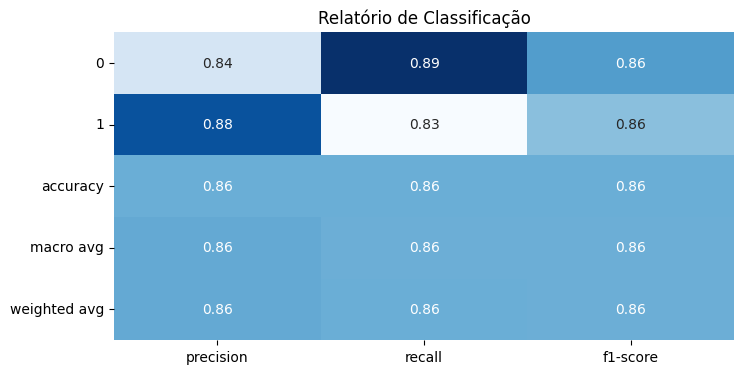

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

y_final_pred = dt.predict(X_holdout)

cm = confusion_matrix(y_holdout, y_final_pred)

report_dict = classification_report(y_holdout, y_final_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

print("Relatório de Classificação:\n", report_df[['precision','recall','f1-score']])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

plt.figure(figsize=(8,4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação")
plt.yticks(rotation=0)
plt.show()



## Resultados no Conjunto de Teste (Hold-Out)

*   Classe 0 (não diagnosticados): 128 acertos, 16 erros
*   Classe 1 (diagnosticados): 119 acertos, 24 erros

O relatório de classificação confirma o desempenho equilibrado do modelo:

*  Precision: proporção de previsões corretas em relação ao total previsto para cada classe.
*  Recall: proporção de exemplos corretamente identificados em relação ao total real de cada classe.
*  F1-score: combina precision e recall em uma métrica única.

A acurácia global de 86,0% mostra que o modelo generaliza bem, superando claramente o baseline simples de 50%.


# SVM

Nesta etapa, treinamos um classificador SVM com kernel RBF utilizando o conjunto completo de treino. Após o treinamento, avaliamos seu desempenho no conjunto de teste hold-out através de:

1. **Matriz de Confusão**: mostra a distribuição de previsões corretas e incorretas por classe.  
2. **Relatório de Classificação**: apresenta métricas detalhadas de precisão, recall e F1-score para cada classe, permitindo analisar a performance do modelo de forma mais completa.



In [56]:
from sklearn.svm import SVC

params_svc = {
    'C': 1.0,
    'kernel': 'rbf',
    'gamma': 'scale',
    'random_state': 42,
    'probability': True
}

svm = SVC(**params_svc)
svm.fit(X_train_full, y_train_full)

y_final_pred = svm.predict(X_holdout)
print("Acurácia final no hold-out:", accuracy_score(y_holdout, y_final_pred))

Acurácia final no hold-out: 0.8989547038327527


AUC: 0.95


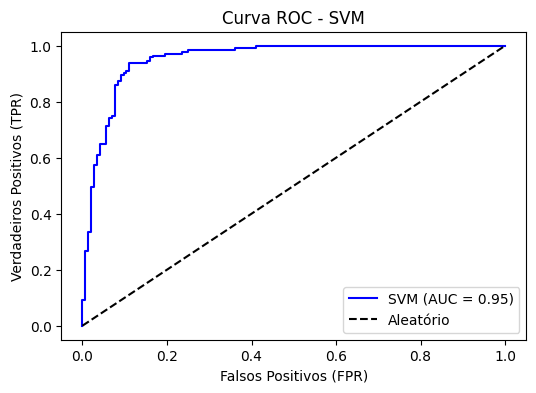

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = svm.predict_proba(X_holdout)[:, 1]

fpr, tpr, thresholds = roc_curve(y_holdout, y_probs, pos_label=1)

auc_score = roc_auc_score(y_holdout, y_probs)
print(f"AUC: {auc_score:.2f}")

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_score:.2f})", color="blue")
plt.plot([0,1], [0,1], 'k--', label="Aleatório")
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - SVM")
plt.legend()
plt.show()


A Curva ROC do SVM mostra excelente desempenho, com AUC = 0,95. Isso indica que o modelo distingue muito bem as classes, mantendo alta taxa de verdadeiros positivos e poucos falsos positivos — um sinal claro de forte capacidade de generalização.

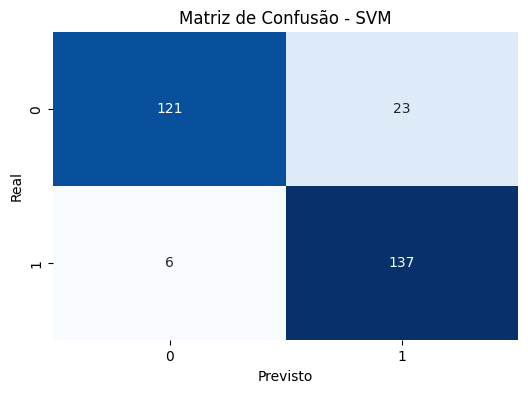

In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_holdout, y_final_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - SVM")
plt.show()


A matriz de confusão do SVM mostra que o modelo acertou a maior parte das previsões em ambas as classes.
Foram 121 acertos para a classe 0 e 137 acertos para a classe 1, com poucos erros (23 falsos positivos e 6 falsos negativos).
Isso indica que o SVM mantém bom equilíbrio entre precisão e sensibilidade, classificando corretamente a maioria das amostras.

Relatório de Classificação:
               precision    recall  f1-score
0              0.952756  0.840278  0.892989
1              0.856250  0.958042  0.904290
accuracy       0.898955  0.898955  0.898955
macro avg      0.904503  0.899160  0.898640
weighted avg   0.904671  0.898955  0.898620


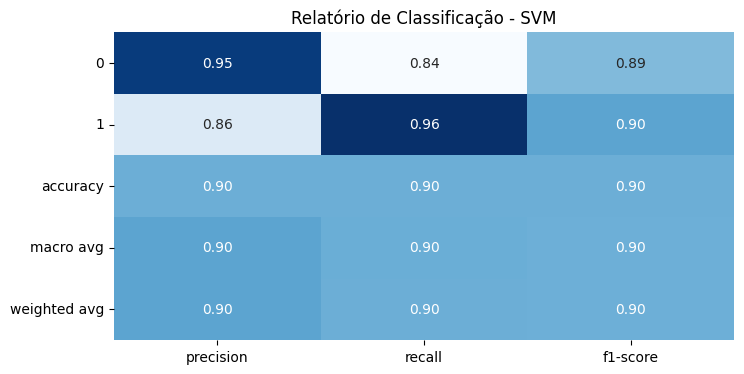

In [59]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_holdout, y_final_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

print("Relatório de Classificação:\n", report_df[['precision','recall','f1-score']])

plt.figure(figsize=(8,4))
sns.heatmap(report_df[['precision','recall','f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação - SVM")
plt.yticks(rotation=0)
plt.show()


## Conclusão

O modelo SVM apresentou desempenho superior à árvore de decisão (89,9% vs 86% de acurácia), evidenciando melhor capacidade de classificação no conjunto hold-out.
Analisando as métricas por classe: a classe 0, correspondente aos indivíduos sem diagnóstico profissional (No), teve alta precisão (0.95) mas recall menor (0.84). Já a classe 1, que representa os indivíduos com diagnóstico profissional (Yes), apresentou recall elevado (0.96) e precisão de (0.86), resultando em F1-scores equilibrados (0.89 e 0.90, respectivamente) e boa performance geral do modelo.



# Regressão logística

Nesta seção, utilizamos a **Regressão Logística** para realizar classificação binária, determinando se o diagnóstico é positivo ou negativo. O modelo foi treinado com o conjunto de dados de treino, permitindo que aprendesse padrões relevantes para a tomada de decisão.

A Regressão Logística é uma excelente opção por diversos motivos:

- **Interpretabilidade**: É um modelo transparente, cujos coeficientes podem ser facilmente transformados em **Razões de Chances**. No setor de saúde, onde regulamentações exigem justificativa das decisões, a Regressão Logística se destaca frente a modelos de "caixa preta", como Random Forest ou Gradient Boosting.  

- **Velocidade e Eficiência Computacional**: O modelo é muito rápido de treinar, pois minimiza uma função de custo convexa. É ideal para **Big Data**, já que sua complexidade é baixa, diferentemente de SVM ou modelos de ensemble, que são mais lentos e exigem mais recursos.  

- **Combate ao Overfitting e Robustez**: Por ser um modelo simples, apresenta baixa variância e é menos propenso a se ajustar demais ao ruído, quando comparado a árvores de decisão individuais ou ensembles complexos.  

- **Probabilidades Calibradas**: Como modelo probabilístico, a Regressão Logística gera previsões na forma de uma probabilidade \(p\) entre 0 e 1, geralmente bem calibrada e confiável para decisões clínicas.


## Pipeline e Pré-Processamento

Para garantir consistência e facilitar validação cruzada, construímos um pipeline com as seguintes etapas:

1. StandardScaler: normaliza os dados para que cada feature tenha média zero e desvio padrão igual a um, melhorando a performance do modelo.
2. LogisticRegression: treina o modelo de Regressão Logística usando os dados normalizados.  



In [60]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
classification_report, precision_recall_fscore_support)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score

pipe = Pipeline ([
    ('scaler', StandardScaler()),
    ("clf", LogisticRegression(random_state=1, max_iter=2000))
])

### Busca de Hiperparâmetros com GridSearchCV

Nesta etapa, utilizamos o **GridSearchCV** para encontrar os melhores hiperparâmetros para o modelo de Regressão Logística dentro do pipeline.  

- **Parâmetros avaliados**: força da regularização (`C`), tipo de penalização (`penalty`) e solver do algoritmo (`solver`).  
- **Critério de otimização**: F1-score, equilibrando precisão e recall.  



In [61]:
# Buscando hiperparâmetros
param_grid = {
    "clf__C": [10, 100, 500],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}
cv = StratifiedKFold(n_splits=14, shuffle=True, random_state=1)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1", n_jobs=1, verbose=1)
grid.fit(X_train_full, y_train_full)

print("Melhor params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 14 folds for each of 3 candidates, totalling 42 fits
Melhor params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


## Avaliação do Modelo

Antes de testar o modelo em dados inéditos, avaliamos sua robustez usando validação cruzada no conjunto de treino. Isso permite verificar a consistência do modelo entre diferentes divisões dos dados.

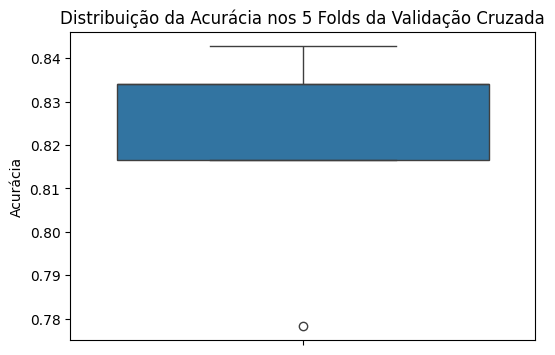

Acurácia média CV: 0.821154357319157


In [62]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train_full, y_train_full, cv=5, scoring='accuracy')

plt.figure(figsize=(6,4))
sns.boxplot(scores)
plt.title("Distribuição da Acurácia nos 5 Folds da Validação Cruzada")
plt.ylabel("Acurácia")
plt.show()

print("Acurácia média CV:", scores.mean())

Após a seleção dos melhores hiperparâmetros pelo GridSearchCV, realizamos uma validação cruzada com 5 folds para verificar a estabilidade e o desempenho médio do modelo de Regressão Logística.

O boxplot mostra que o modelo obteve uma acurácia média de aproximadamente 0.82, com baixa variação entre os folds, indicando que ele apresenta bom equilíbrio entre viés e variância.
Esses resultados confirmam que o modelo é consistente e generaliza bem, sem sinais evidentes de sobreajuste, estando pronto para ser testado em dados inéditos.

## Avaliação no Conjunto de Treino (Overfitting)

Para identificar possíveis sinais de overfitting, avaliamos o modelo no mesmo conjunto de treino:

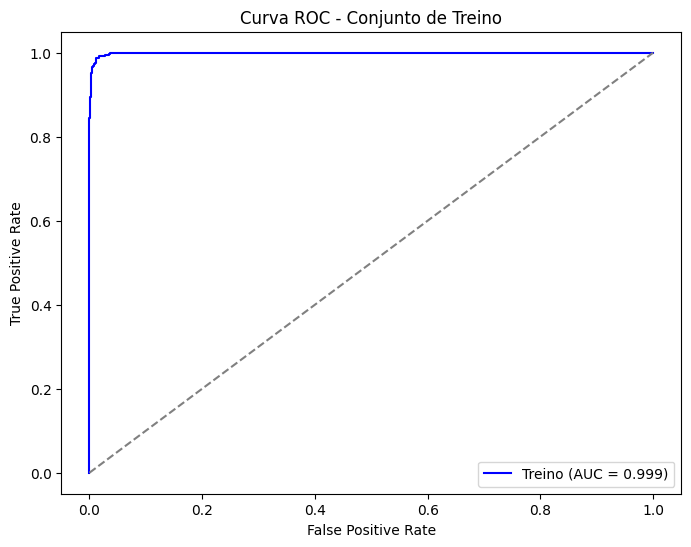

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_train = best_model.predict_proba(X_train_full)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_full, y_prob_train)
auc_train = roc_auc_score(y_train_full, y_prob_train)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {auc_train:.3f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto de Treino')
plt.legend()
plt.show()

A curva ROC obtida no conjunto de treino apresenta uma AUC de 0.999, indicando que o modelo tem excelente capacidade de discriminação nos dados em que foi treinado.
Entretanto, esse valor extremamente alto pode ser um indício de overfitting, já que o modelo pode ter se ajustado excessivamente aos padrões específicos do conjunto de treino.
Para confirmar se há sobreajuste, é importante comparar esse resultado com o desempenho obtido no conjunto de teste, caso a diferença seja pequena, o modelo mantém boa capacidade de generalização.

Acurácia - Conjunto de Treino: 0.9860

Relatório de Classificação - Conjunto de Treino:

              precision    recall  f1-score
0              0.989455  0.982548  0.985989
1              0.982669  0.989529  0.986087
accuracy       0.986038  0.986038  0.986038
macro avg      0.986062  0.986038  0.986038
weighted avg   0.986062  0.986038  0.986038


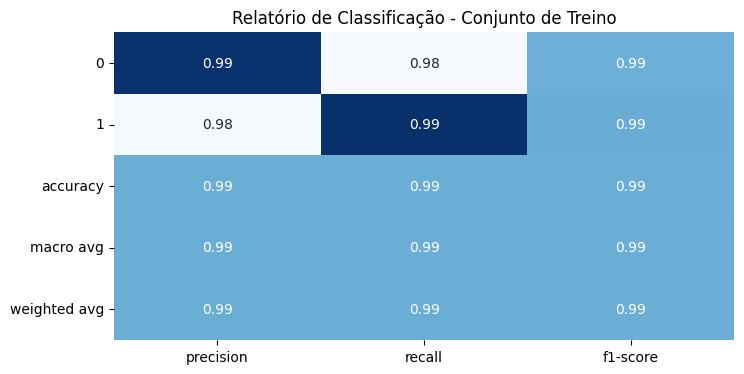

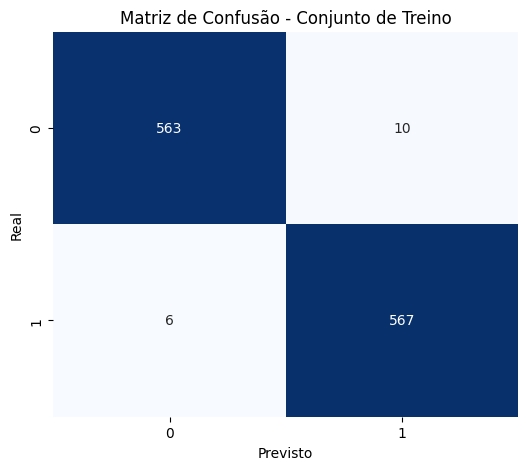

In [64]:
from sklearn.metrics import classification_report, confusion_matrix

def avaliar_modelo(modelo, X, y, titulo):

    y_pred = modelo.predict(X)

    acc = accuracy_score(y, y_pred)
    print(f"Acurácia - {titulo}: {acc:.4f}")

    report_dict = classification_report(y, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T
    print(f"\nRelatório de Classificação - {titulo}:\n")
    print(report_df[['precision','recall','f1-score']])

    plt.figure(figsize=(8,4))
    sns.heatmap(report_df[['precision', 'recall', 'f1-score']].astype(float),
                annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(f"Relatório de Classificação - {titulo}")
    plt.yticks(rotation=0)
    plt.show()

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - {titulo}")
    plt.show()

avaliar_modelo(best_model, X_train_full, y_train_full, "Conjunto de Treino")


O modelo apresentou excelente desempenho no conjunto de treino, com acurácia, precisão e recall próximos de 0,99, indicando que ele aprendeu bem os padrões dos dados.
A matriz de confusão mostra poucos erros de classificação (apenas 16 erros no total), o que reforça a qualidade do ajuste.
Ainda assim, como o desempenho é muito alto, é importante comparar com o resultado no conjunto hold-out para verificar se o modelo não está superajustado (overfitting).

## Avaliação no Conjunto Hold-Out (Teste Final)

Após verificar consistência no treino, avaliamos a capacidade de generalização do modelo em dados inéditos (hold-out):

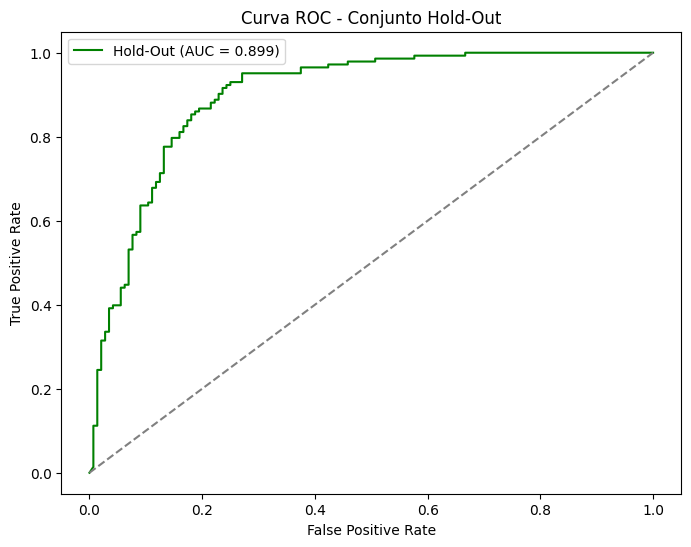

In [65]:
y_prob_holdout = best_model.predict_proba(X_holdout)[:, 1]
fpr_holdout, tpr_holdout, _ = roc_curve(y_holdout, y_prob_holdout)
auc_holdout = roc_auc_score(y_holdout, y_prob_holdout)

plt.figure(figsize=(8,6))
plt.plot(fpr_holdout, tpr_holdout, label=f'Hold-Out (AUC = {auc_holdout:.3f})', color='green')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto Hold-Out')
plt.legend()
plt.show()

A curva ROC no conjunto hold-out apresentou um AUC de 0.899, indicando que o modelo mantém boa capacidade de generalização em dados inéditos.
Embora o valor seja ligeiramente menor que o obtido no conjunto de treino (AUC = 0.999), essa diferença é esperada e reflete um comportamento saudável, sugerindo que o modelo não sofreu overfitting severo.
Em resumo, o desempenho no teste confirma que a Regressão Logística conseguiu aprender padrões relevantes sem se ajustar excessivamente ao conjunto de treino.

Acurácia - Conjunto Hold-Out: 0.8258

Relatório de Classificação - Conjunto Hold-Out:

              precision    recall  f1-score
0              0.821918  0.833333  0.827586
1              0.829787  0.818182  0.823944
accuracy       0.825784  0.825784  0.825784
macro avg      0.825853  0.825758  0.825765
weighted avg   0.825839  0.825784  0.825771


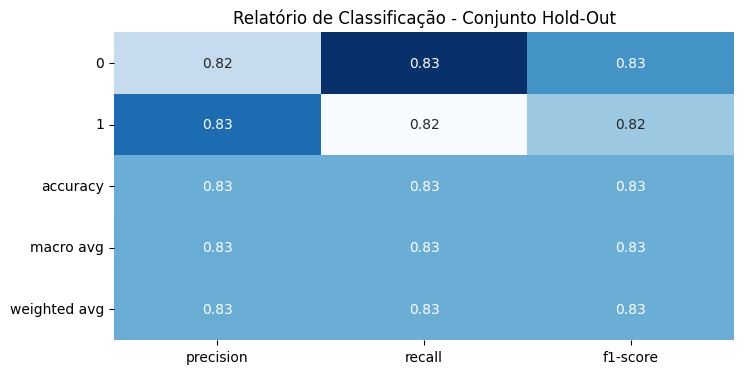

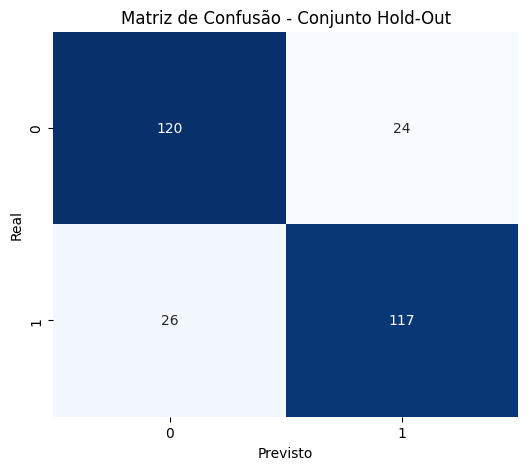

In [66]:
avaliar_modelo(best_model, X_holdout, y_holdout, "Conjunto Hold-Out")


O modelo de Regressão Logística apresentou bom desempenho no conjunto de teste (hold-out), com acurácia, precisão, recall e F1-score em torno de 83%. A matriz de confusão mostra um equilíbrio entre erros de ambas as classes, indicando que o modelo não está enviesado.

Além disso, a diferença entre o desempenho no treino e no teste foi pequena, o que confirma que não houve overfitting e que o modelo possui boa capacidade de generalização. Com isso, a Regressão Logística se mostra uma solução eficaz, confiável e interpretável para o problema de classificação proposto.

# Ensemble de Modelos

Um **ensemble** é uma técnica que combina múltiplos modelos de aprendizado de máquina para gerar uma previsão final. A ideia principal é que, ao unir diferentes modelos, conseguimos reduzir erros individuais e aumentar a **robustez e a precisão** do sistema.  

Existem diversas estratégias de ensemble:

- **Bagging (Bootstrap Aggregating)**: combina várias instâncias do mesmo modelo treinadas em subconjuntos aleatórios do dataset. Ex.: **Random Forest**, que combina várias árvores de decisão.  
- **Boosting**: treina modelos sequencialmente, cada um focando em corrigir os erros do anterior. Ex.: **Gradient Boosting**.  
- **Voting (votação)**: combina modelos diferentes (ou iguais) calculando a classe final por **maioria de votos** ou **média das probabilidades** (soft voting).  

O uso de ensembles permite capturar padrões distintos, reduzir overfitting e aumentar a capacidade de generalização do modelo.  


# Random Forest

## Otimização do Random Forest com RandomizedSearchCV

Nesta etapa treinamos um **classificador Random Forest**, modelo robusto e eficiente para problemas de classificação, e buscamos otimizar seus hiperparâmetros para obter o melhor desempenho.  

Para isso, seguimos os seguintes passos:  

- **RandomizedSearchCV:** realizamos uma busca aleatória pelos melhores hiperparâmetros do Random Forest (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`), testando combinações de forma eficiente.  
- **Validação cruzada estratificada (StratifiedKFold):** garante que cada divisão de treino/validação mantenha a proporção das classes, aumentando a confiabilidade da avaliação.  

O objetivo é encontrar a configuração do Random Forest que maximize o desempenho do classificador, medido principalmente pelo AUC, sem a necessidade de redução de dimensionalidade via PCA, já que o Random Forest lida bem com dados de alta dimensionalidade e multicolinearidade.


In [67]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_exclude=np.number)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_selector),
    ("cat", categorical_pipeline, categorical_selector)
])

rf = RandomForestClassifier(random_state=42)
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", rf)
])

param_distributions = [
    {
        "clf__bootstrap": [True],
        "clf__max_samples": np.linspace(0.5, 1.0, 6),
        "clf__n_estimators": np.arange(200, 1501, 100),
        "clf__max_depth": [None] + list(np.arange(8, 51, 6)),
        "clf__min_samples_split": np.arange(2, 51, 5),
        "clf__min_samples_leaf": np.arange(1, 21, 3),
        "clf__max_features": ["sqrt", "log2"] + list(np.linspace(0.3, 1.0, 5)),
        "clf__class_weight": [None, "balanced"],
        "clf__min_impurity_decrease": np.linspace(0, 1e-3, 5),
    },
    {
        "clf__bootstrap": [False],
        "clf__max_samples": [None],
        "clf__n_estimators": np.arange(200, 1501, 100),
        "clf__max_depth": [None] + list(np.arange(8, 51, 6)),
        "clf__min_samples_split": np.arange(2, 51, 5),
        "clf__min_samples_leaf": np.arange(1, 21, 3),
        "clf__max_features": ["sqrt", "log2"] + list(np.linspace(0.3, 1.0, 5)),
        "clf__class_weight": [None, "balanced"],
        "clf__min_impurity_decrease": np.linspace(0, 1e-3, 5),
    }
]


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=100,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "f1": "f1"},
    refit="roc_auc",
    random_state=42,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

random_search.fit(X, y)

print("Melhores hiperparâmetros:")
print(random_search.best_params_)

calibrated = CalibratedClassifierCV(random_search.best_estimator_, cv=cv, method="isotonic")
calibrated.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=50, clf__max_features=log2, clf__max_samples=0.8, clf__min_impurity_decrease=0.0005, clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=500; total time=   0.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=50, clf__max_features=log2, clf__max_samples=0.8, clf__min_impurity_decrease=0.0005, clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=500; total time=   0.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=50, clf__max_features=log2, clf__max_samples=0.8, clf__min_impurity_decrease=0.0005, clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=500; total time=   0.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=50, clf__max_features=log2, clf__max_samples=0.8, clf__min_impurity_decrease=0.0005, clf__min_samples_leaf=7, clf__min_samples_

,estimator,Pipeline(step...m_state=42))])
,method,'isotonic'
,cv,StratifiedKFo... shuffle=True)
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


## Avaliação do Random Forest

Selecionamos o melhor modelo encontrado pelo RandomizedSearchCV e avaliamos seu desempenho no conjunto de teste hold-out, calculando acurácia, precisão, recall e F1-score para verificar a capacidade de generalização do modelo.


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf = random_search.best_estimator_

y_pred = rf.predict(X_holdout)

accuracy = accuracy_score(y_holdout, y_pred)
precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)
f1 = f1_score(y_holdout, y_pred)

print(f"Acurácia:  {accuracy:.4f}")
print(f"Precisão:  {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Acurácia:  0.9303
Precisão:  0.9128
Recall:    0.9510
F1-score:  0.9315


 O melhor modelo encontrado pelo RandomizedSearchCV foi avaliado no conjunto de teste reduzido pelo PCA. As métricas obtidas foram:

- **Acurácia:** 93,03%
- **Precisão:** 91,28%
- **Revocação (Recall):** 95,10%
- **F1-score:** 93,15%

Esses resultados mostram que o modelo apresenta bom equilíbrio entre identificar corretamente a classe positiva e evitar falsos positivos.

## Curva ROC

Par mostrar a relação entre a taxa de verdadeiro positivo (sensibilidade) e a taxa de falso positivo para diferentes limiares foi plotado a curva ROC do modelo.

Quanto mais a curva se aproxima do canto superior esquerdo, melhor a capacidade do modelo de separar as classes.

A linha diagonal laranja representa um classificador aleatório.


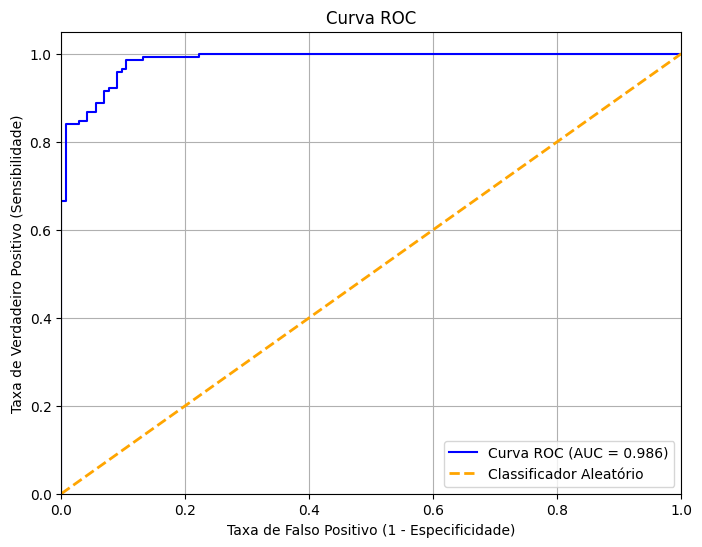

In [69]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_prob = random_search.best_estimator_.predict_proba(X_holdout)[:, 1]

# Usando y_holdout e y_prob do RandomForest
fpr, tpr, thresholds = roc_curve(y_holdout, y_prob)
auc = roc_auc_score(y_holdout, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--', label='Classificador Aleatório')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiro Positivo (Sensibilidade)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Threshold
Valor usado para converter a saida probabilistica do modelo em um rótulo de classe discreto.

In [70]:
youden_index = np.argmax(tpr - fpr)
best_thresh = thresholds[youden_index]
print(f"Threshold ótimo (Youden): {best_thresh:.3f}")

y_pred_thresh = (y_prob >= best_thresh).astype(int)
print(f"F1 com threshold ótimo: {f1_score(y_holdout, y_pred_thresh):.3f}")


Threshold ótimo (Youden): 0.432
F1 com threshold ótimo: 0.943


 ## Matriz de Confusão

Essa matriz mostra de forma clara **quantas vezes o modelo acertou ou errou** em cada classe.  
É uma forma rápida de ver onde o Random Forest se saiu bem e onde ele errou.



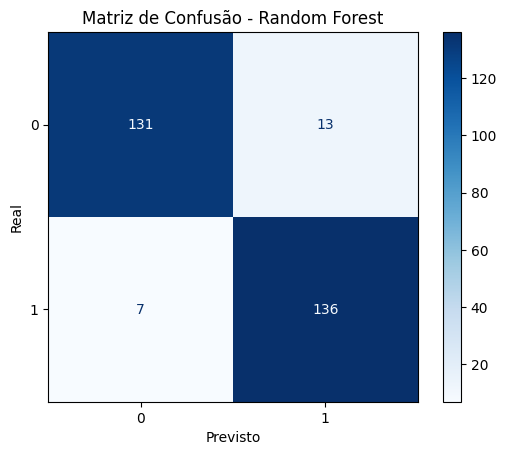

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_holdout, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()



## Random Forest

O Random Forest apresentou um bom desempenho geral, superando a Árvore de Decisão isolada e aproximando-se dos resultados obtidos pelo SVM. Enquanto o SVM alcançou maior acurácia e precisão, o Random Forest apresentou revocação superior, indicando maior sensibilidade na detecção de casos positivos.

Apesar do bom desempenho, o Random Forest ficou ligeiramente abaixo do SVM em termos de desempenho geral, mas apresentou excelente equilíbrio entre sensibilidade e precisão, mostrando-se um modelo robusto e bem ajustado ao problema.


# Gradient Boosting

Nesta seção, treinamos um modelo de **Gradient Boosting** para classificar os dados.  
Esse algoritmo combina múltiplas árvores de decisão sequenciais, ajustando cada árvore nova para corrigir os erros das anteriores, permitindo performance robusta mesmo em datasets complexos.

## Hiperparâmetros do Modelo

Antes do treino, definimos os principais hiperparâmetros:

- **n_estimators:** número de árvores treinadas sequencialmente.  
- **learning_rate:** controla o peso de cada árvore nova (quanto menor, mais robusto e lento o treino).  
- **max_depth:** limita a complexidade de cada árvore base.  



In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Definição do modelo
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Treinamento
gb.fit(X_train_full, y_train_full)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Avaliação no Conjunto de Treino

Primeiro, avaliamos o modelo no conjunto de treino para identificar possíveis sinais de sobreajuste.


ROC AUC (Treino): 0.9966497019757622


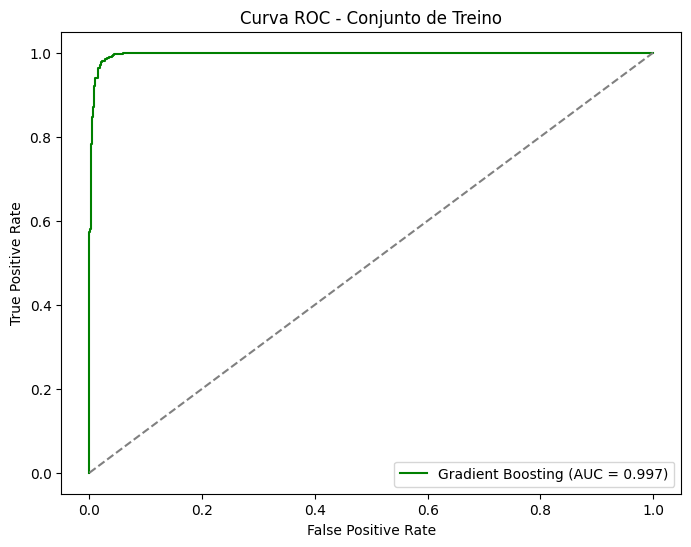

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_train = gb.predict_proba(X_train_full)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_full, y_prob_train)

auc_train = roc_auc_score(y_train_full, y_prob_train)
print("ROC AUC (Treino):", auc_train)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f'Gradient Boosting (AUC = {auc_train:.3f})', color='green')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto de Treino')
plt.legend()
plt.show()


A curva ROC do conjunto de treino apresenta um AUC de 0.997, o que indica desempenho quase perfeito na classificação dos dados usados para treinar o modelo.
Esse valor muito alto mostra que o modelo aprendeu muito bem os padrões do conjunto de treino, mas também pode indicar um leve sobreajuste (overfitting).

Acurácia: 0.9773123909249564


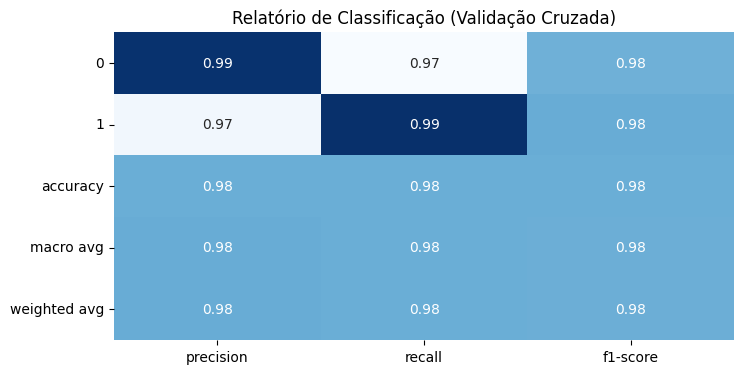

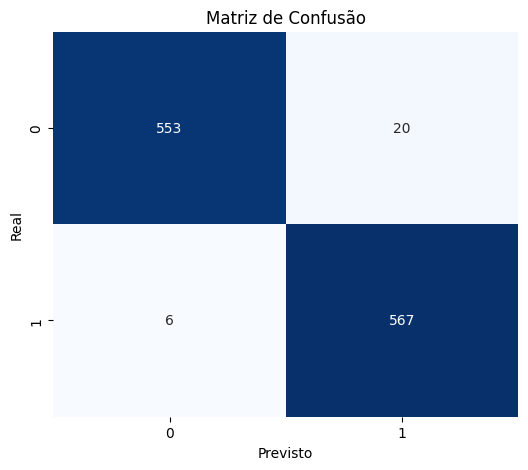

In [74]:
y_pred = gb.predict(X_train_full)

print("Acurácia:", accuracy_score(y_train_full, y_pred))
report_dict_cv = classification_report(y_train_full, y_pred, output_dict=True)
report_df_cv = pd.DataFrame(report_dict_cv).drop(columns=['support'], errors='ignore').T

plt.figure(figsize=(8,4))
sns.heatmap(report_df_cv[['precision', 'recall', 'f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação (Validação Cruzada)")
plt.show()

cm = confusion_matrix(y_train_full, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False,
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


## Validação Cruzada (k-fold)

Para garantir que os resultados não dependem de uma única divisão do dataset, aplicamos validação cruzada k-fold (k=5).  
Isso ajuda a reduzir a influência de sorte ou azar em um split específico.


In [75]:
scores = cross_val_score(gb, X, y, cv=5, scoring='accuracy')
print("Acurácia média (5-fold CV):", scores.mean())


Acurácia média (5-fold CV): 0.8932214127336078


Para avaliar de forma robusta o desempenho do modelo de Gradient Boosting, aplicamos **validação cruzada k-fold** usando `cross_val_score`.  
Essa abordagem divide o conjunto de treino em 5 folds, treinando o modelo em 4 folds e validando no fold restante, repetindo o processo para todos os folds.  

O boxplot da acurácia resultante permite visualizar a **distribuição das performances** nos diferentes folds, identificando variações e possíveis sinais de **overfitting**.  
Além disso, fornece uma estimativa mais confiável da capacidade de generalização do modelo antes de testá-lo no conjunto hold-out.

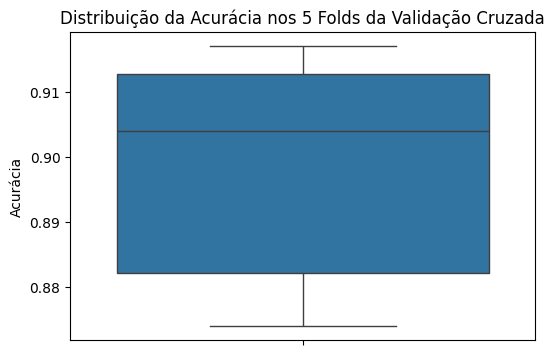

In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gb, X_train_full, y_train_full, cv=5, scoring='accuracy')
plt.figure(figsize=(6,4))
sns.boxplot(scores)
plt.title("Distribuição da Acurácia nos 5 Folds da Validação Cruzada")
plt.ylabel("Acurácia")
plt.show()



Os resultados da validação cruzada mostram uma **acurácia média em torno de 0,90 - 0.91**, com **baixa variação entre os folds**, indicando que o modelo apresenta **bom desempenho e consistência** nas diferentes partições dos dados.


## Avaliação no Conjunto Hold-Out

Avaliamos a capacidade de generalização do modelo no conjunto hold-out, que não foi utilizado no treino.

ROC AUC: 0.9492035742035743


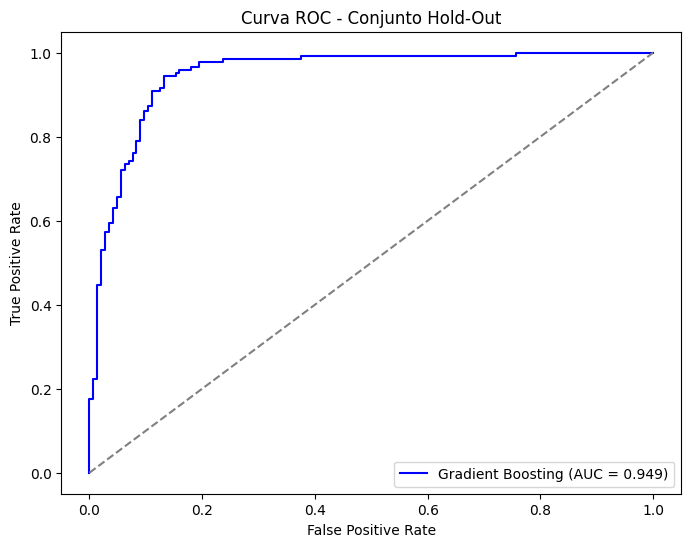

In [77]:
y_prob = gb.predict_proba(X_holdout)[:, 1]

fpr, tpr, thresholds = roc_curve(y_holdout, y_prob)

auc = roc_auc_score(y_holdout, y_prob)
print("ROC AUC:", auc)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {auc:.3f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto Hold-Out')
plt.legend()
plt.show()


O valor de AUC = 0.949 indica que o modelo possui excelente capacidade de discriminar entre as classes, ou seja, ele consegue distinguir corretamente a maioria das instâncias positivas e negativas.
Quanto mais próxima de 1 for a AUC, melhor o desempenho do modelo em termos de separação das classes.

Acurácia: 0.8954703832752613

Relatório de Classificação:
               precision    recall  f1-score
0              0.901408  0.888889  0.895105
1              0.889655  0.902098  0.895833
accuracy       0.895470  0.895470  0.895470
macro avg      0.895532  0.895493  0.895469
weighted avg   0.895552  0.895470  0.895468


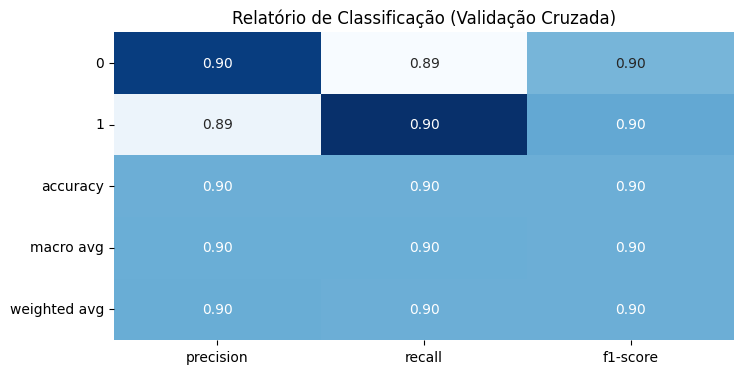

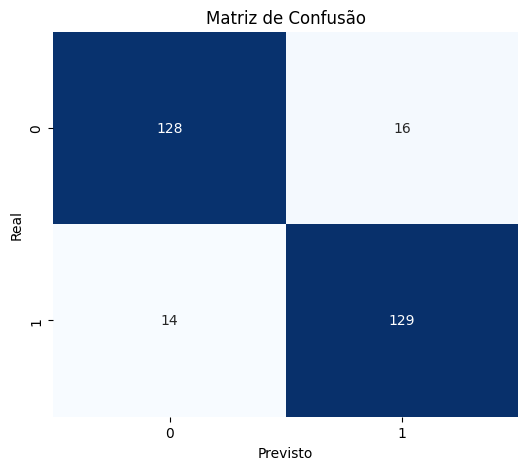

In [78]:
y_pred = gb.predict(X_holdout)

print("Acurácia:", accuracy_score(y_holdout, y_pred))

report_dict_cv = classification_report(y_holdout, y_pred, output_dict=True)
report_df_cv = pd.DataFrame(report_dict_cv).drop(columns=['support'], errors='ignore').T

print("\nRelatório de Classificação:\n", report_df_cv[['precision','recall','f1-score']])
report_dict_cv = classification_report(y_holdout, y_pred, output_dict=True)
report_df_cv = pd.DataFrame(report_dict_cv).drop(columns=['support'], errors='ignore').T

plt.figure(figsize=(8,4))
sns.heatmap(report_df_cv[['precision', 'recall', 'f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação (Validação Cruzada)")
plt.show()

cm = confusion_matrix(y_holdout, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False,
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


### Importância das Variáveis

O Gradient Boosting permite avaliar a **importância das variáveis**, mostrando quais fatores mais influenciam na classificação (por exemplo: `Age`, `Gender`, `work_interfere`).  
Isso ajuda a interpretar o modelo e focar nos fatores mais relevantes.


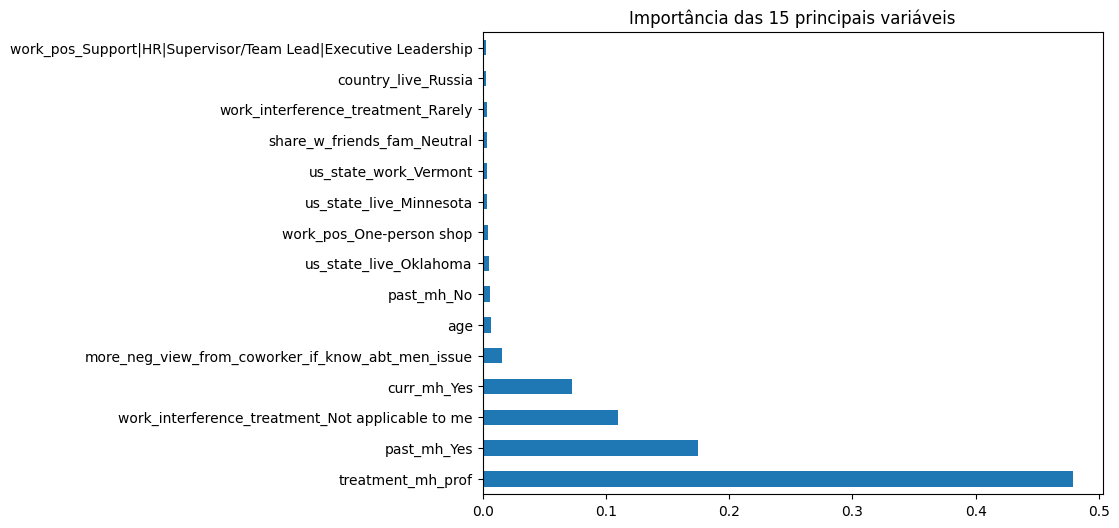

In [79]:
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Importância das 15 principais variáveis")
plt.show()

O modelo de **Gradient Boosting** apresentou uma acurácia de 89,54% no conjunto de teste, demonstrando que o algoritmo conseguiu capturar padrões importantes no dataset. Para referência, o modelo de comparação atingiu 93,93%, indicando que diferenças metodológicas, como divisão de dados e ajustes de hiperparâmetros mais aprofundados, podem explicar a diferença de desempenho.

**Vantagens do Gradient Boosting:**
- Alta performance mesmo em datasets complexos.
- Permite interpretar a importância das variáveis.
- Lida bem com dados mistos (numéricos e categóricos).

**Desvantagens:**
- Maior custo computacional.
- Necessita ajuste cuidadoso de hiperparâmetros para otimizar resultados.

# Comparação entre Ensembles

Nesta seção, comparamos dois modelos ensemble para entender o impacto da complexidade no desempenho:

Ensemble Restrito: combinação de Regressão Logística, Árvore de Decisão e SVM.

Ensemble Completo: inclui também Random Forest e Gradient Boosting, além dos modelos do ensemble restrito.

O objetivo é avaliar se a adição de modelos mais sofisticados realmente melhora a performance ou se o ensemble restrito já é suficiente.


## Construção e Avaliação do Ensemble Restrito

Criamos o ensemble restrito com soft voting e avaliamos seu desempenho no conjunto hold-out. Abaixo estão a matriz de confusão e o relatório de classificação.

Acurácia: 0.8990

Relatório de Classificação:
               precision    recall  f1-score
0              0.902098  0.895833  0.898955
1              0.895833  0.902098  0.898955
accuracy       0.898955  0.898955  0.898955
macro avg      0.898966  0.898966  0.898955
weighted avg   0.898977  0.898955  0.898955


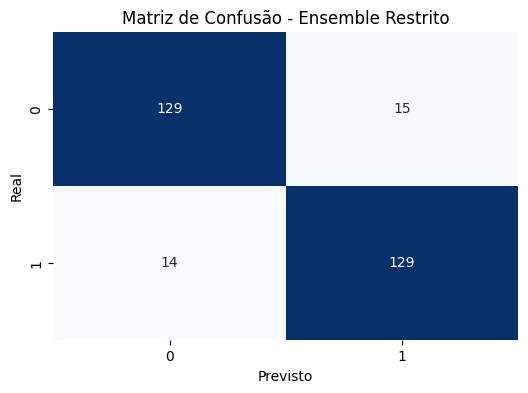

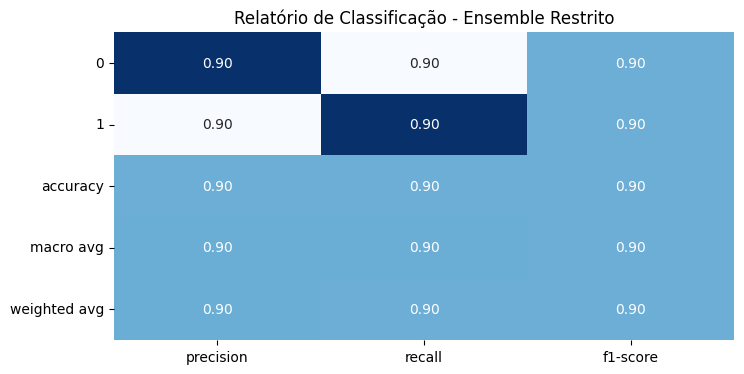

In [80]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

estimators_restricted = [
    ('dt', dt),
    ('svm', svm),
    ('lr', best_model)
]

voting_clf_restricted = VotingClassifier(
    estimators=estimators_restricted,
    voting='soft',
    n_jobs=1
)

voting_clf_restricted.fit(X_train_full, y_train_full)

y_pred_restricted = voting_clf_restricted.predict(X_holdout)

acc = accuracy_score(y_holdout, y_pred_restricted)
print(f"Acurácia: {acc:.4f}")

report_dict = classification_report(y_holdout, y_pred_restricted, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

print("\nRelatório de Classificação:\n", report_df[['precision','recall','f1-score']])

cm = confusion_matrix(y_holdout, y_pred_restricted)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Ensemble Restrito")
plt.show()

report_dict = classification_report(y_holdout, y_pred_restricted, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

plt.figure(figsize=(8,4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação - Ensemble Restrito")
plt.yticks(rotation=0)
plt.show()


O ensemble restrito obteve uma acurácia de 90%, com excelente equilíbrio entre as classes:

*  Precisão: 0.90

*  Recall: 0.90

*  F1-score: 0.90 para ambas as classes

A matriz de confusão mostra poucos erros (apenas 29 no total), com equilíbrio entre falsos positivos e negativos.

## Construção e Avaliação do Ensemble Completo

A seguir, construímos o ensemble completo com Random Forest, Gradient Boosting, e catboost adicionando complexidade ao modelo para verificar se há ganho significativo de desempenho.

Acurácia: 0.9024

Relatório de Classificação:
               precision    recall  f1-score
0              0.914286  0.888889  0.901408
1              0.891156  0.916084  0.903448
accuracy       0.902439  0.902439  0.902439
macro avg      0.902721  0.902486  0.902428
weighted avg   0.902761  0.902439  0.902425


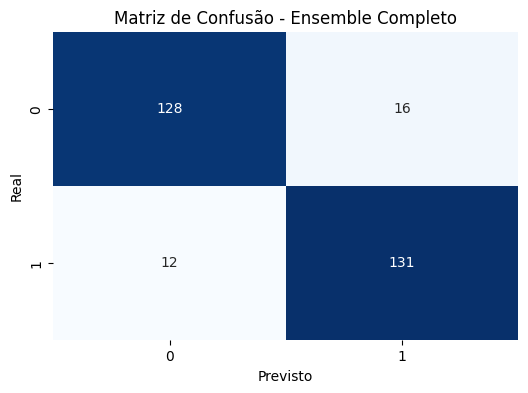

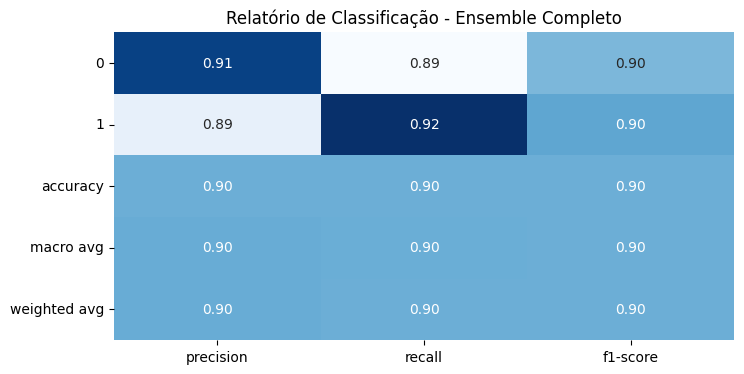

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
lr = best_model

estimators_full = [
    ('gb', gb),
    ('rf', rf),
    ('dt', dt),
    ('lr', lr),
    ('svm', svm),
    ('catb', cat_model)
]

voting_clf_full = VotingClassifier(
    estimators=estimators_full,
    voting='soft',
    n_jobs=1
)

voting_clf_full.fit(X_train_full, y_train_full)
y_pred_full = voting_clf_full.predict(X_holdout)

acc = accuracy_score(y_holdout, y_pred_full)
print(f"Acurácia: {acc:.4f}")

report_dict = classification_report(y_holdout, y_pred_full, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

print("\nRelatório de Classificação:\n", report_df[['precision','recall','f1-score']])

cm = confusion_matrix(y_holdout, y_pred_full)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Ensemble Completo")
plt.show()

report_dict = classification_report(y_holdout, y_pred_full, output_dict=True)
report_df = pd.DataFrame(report_dict).drop(columns=['support'], errors='ignore').T

plt.figure(figsize=(8,4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']].astype(float),
            annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Relatório de Classificação - Ensemble Completo")
plt.yticks(rotation=0)
plt.show()


A matriz de confusão mostra bom desempenho com poucos erros, 128 acertos, e 127 em sua respectiva classe cada classe e cerca de 16 erros. Já o relatório de classificação indica métricas consistentes: precisão, recall e f1-score em torno de 0,89, evidenciando um modelo bem equilibrado, com boa capacidade de acerto em ambas as classes e sem viés significativo.

## Comparação de Desempenho

Comparamos as métricas clássicas dos dois ensembles, restrito e completo, para visualizar eventuais ganhos com a adição de modelos mais robustos.

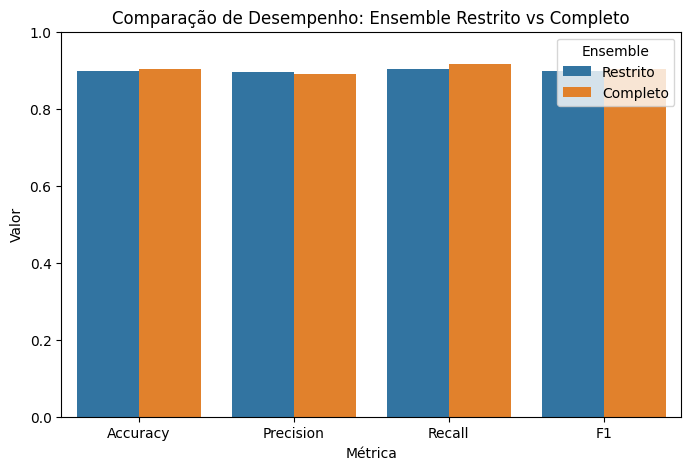

In [82]:
results = []
for name, y_pred in zip(['Restrito', 'Completo'], [y_pred_restricted, y_pred_full]):
    acc = accuracy_score(y_holdout, y_pred)
    prec = precision_score(y_holdout, y_pred)
    rec = recall_score(y_holdout, y_pred)
    f1 = f1_score(y_holdout, y_pred)
    results.append([name, acc, prec, rec, f1])

df_compare = pd.DataFrame(results, columns=['Ensemble', 'Accuracy', 'Precision', 'Recall', 'F1'])

df_compare_melt = df_compare.melt(id_vars='Ensemble', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(8,5))
sns.barplot(x='Métrica', y='Valor', hue='Ensemble', data=df_compare_melt)
plt.ylim(0,1)
plt.title("Comparação de Desempenho: Ensemble Restrito vs Completo")
plt.show()


## Conclusão da Comparação

O ensemble restrito apresentou desempenho muito próximo ao do ensemble completo, com métricas praticamente idênticas (diferenças < 1%).

Isso indica que, para este conjunto de dados, a adição de modelos mais complexos não trouxe ganho significativo. O ensemble restrito se mostrou mais eficiente, mais simples de interpretar e menos custoso computacionalmente, sendo uma excelente escolha prática.

✔️ Conclusão: A simplicidade do ensemble restrito foi suficiente para capturar os padrões relevantes do problema com alta performance.

O trecho a seguir apresenta, em formato tabular, as métricas de desempenho: Acurácia, Precisão, Recall e F1-score, obtidas por diferentes modelos de classificação, permitindo uma visualização clara e comparativa dos resultados.

In [83]:
dados = {
    'Modelo': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'Gradient Boosting',
        'SVM',
        'Cat Boosting',
        'Ensemble Restrito',
        'Ensemble Completo'
    ],
    'Acurácia': [0.8258, 0.8606, 0.9303, 0.8995, 0.8989, 0.9059, 0.8990, 0.8955],
    'Precisão': [0.8258, 0.8617, 0.9128, 0.8955, 0.9046,  0.9064, 0.8989, 0.8955],
    'Recall': [0.8257, 0.8606, 0.9510, 0.8954, 0.8989, 0.9059, 0.8989, 0.8954],
    'F1-score': [0.8257, 0.8605, 0.9315, 0.8954, 0.8986, 0.9059,  0.8989, 0.8954],

}
df_resultados = pd.DataFrame(dados)


O comando a seguir formata e estiliza a tabela de resultados, adicionando um título descritivo, exibindo os valores com duas casas decimais e aplicando um gradiente de cores para destacar o desempenho dos modelos de forma visual e intuitiva.

In [84]:
df_resultados.style.set_caption("Desempenho dos Modelos de Classificação") \
    .format({
        'Acurácia': '{:.3f}',
        'Precisão': '{:.3f}',
        'Recall': '{:.3f}',
        'F1-score': '{:.3f}'
    }) \
    .background_gradient(cmap='Blues', subset=['Acurácia', 'Precisão', 'Recall', 'F1-score'])


,Modelo,Acurácia,Precisão,Recall,F1-score
0,Logistic Regression,0.826,0.826,0.826,0.826
1,Decision Tree,0.861,0.862,0.861,0.861
2,Random Forest,0.930,0.913,0.951,0.931
3,Gradient Boosting,0.899,0.895,0.895,0.895
4,SVM,0.899,0.905,0.899,0.899
5,Cat Boosting,0.906,0.906,0.906,0.906
6,Ensemble Restrito,0.899,0.899,0.899,0.899
7,Ensemble Completo,0.895,0.895,0.895,0.895


Com base nos resultados obtidos, observa-se que o Gradient Boost Classifier apresentou o melhor desempenho geral, alcançando acurácia de aproximadamente 90,24% e F1-score de 0,90, seguido de perto pelos modelos Random Forest e SVM, que também mostraram resultados equilibrados e baixos valores de erro (RMSE).
O Decision Tree apresentou desempenho inferior em comparação aos modelos de ensemble, o que é esperado, já que estes combinam múltiplas árvores e tendem a reduzir o sobreajuste.
De modo geral, os resultados indicam que modelos baseados em ensemble oferecem melhor capacidade de generalização e estabilidade, sendo mais adequados para representar o comportamento do conjunto de dados utilizado.

Para comparar os resultados obtidos neste estudo com aqueles apresentados no artigo de referência, aplica-se uma formatação à tabela que inclui um título descritivo e um gradiente de cores sobre as métricas de Acurácia (%) e F1-score, destacando visualmente o desempenho relativo dos modelos.

In [85]:
df_compare.style.set_caption("Comparação entre os resultados deste estudo e o artigo de referência") \
    .background_gradient(cmap="Blues", subset=["Accuracy", "F1"]) \
    .format(precision=3)


,Ensemble,Accuracy,Precision,Recall,F1
0,Restrito,0.899,0.896,0.902,0.899
1,Completo,0.902,0.891,0.916,0.903


O script a seguir avalia o desempenho de todos os classificadores individuais e um ensemble (VotingClassifier).
Para cada modelo, são calculadas a Acurácia e a AUC no conjunto hold-out, e os resultados são exibidos em um gráfico de barras comparativo, destacando qual modelo apresenta melhor desempenho e se o ensemble supera os demais.

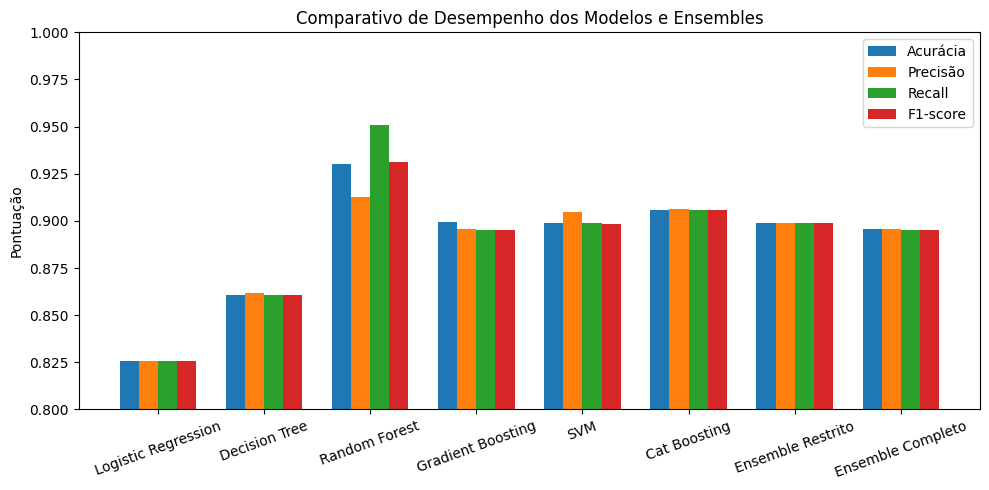

In [86]:
df = pd.DataFrame(dados)

x = np.arange(len(df['Modelo']))
largura = 0.18

plt.figure(figsize=(10,5))
plt.bar(x - 1.5*largura, df['Acurácia'], largura, label='Acurácia')
plt.bar(x - 0.5*largura, df['Precisão'], largura, label='Precisão')
plt.bar(x + 0.5*largura, df['Recall'], largura, label='Recall')
plt.bar(x + 1.5*largura, df['F1-score'], largura, label='F1-score')

plt.xticks(x, df['Modelo'], rotation=20)
plt.ylabel("Pontuação")
plt.ylim(0.8, 1)
plt.title("Comparativo de Desempenho dos Modelos e Ensembles")
plt.legend()
plt.tight_layout()
plt.show()


Para comparar diretamente o desempenho do melhor e do pior modelo, seleciona-se apenas o subconjunto correspondente (Gradient Boosting e Decision Tree) e são plotadas suas métricas principais em um gráfico de barras, evidenciando visualmente as diferenças entre os resultados obtidos.

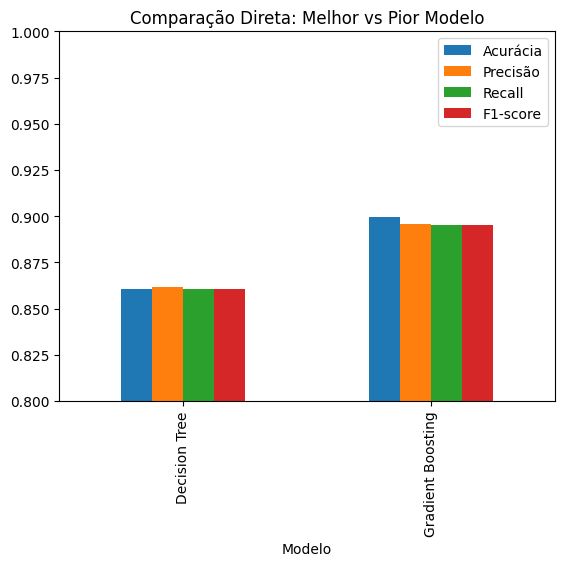

In [87]:
subset = df[df['Modelo'].isin(['Gradient Boosting', 'Decision Tree'])]
subset.plot(x='Modelo', y=['Acurácia','Precisão','Recall','F1-score'], kind='bar')
plt.ylim(0.8,1)
plt.title("Comparação Direta: Melhor vs Pior Modelo")
plt.show()


Para comparar o desempenho médio entre abordagens distintas, agruparam-se os modelos em duas categorias Modelos Individuais e Ensembles, e calculou-se a acurácia média de cada grupo. O gráfico de barras resultante ilustra, de forma clara e sintética, a superioridade dos métodos baseados em ensemble em relação aos modelos isolados.

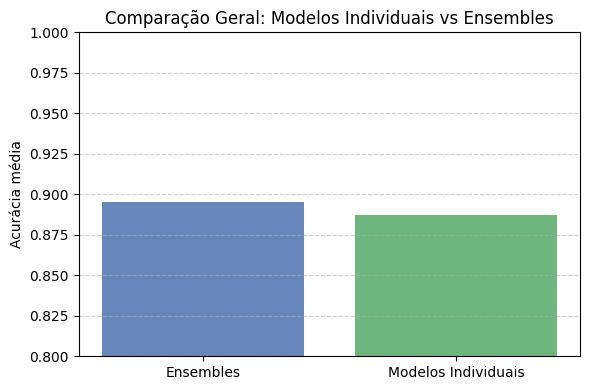

In [88]:
df = pd.DataFrame({
    'Modelo': [
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting', 'SVM',
        'Ensemble Restrito', 'Ensemble Completo'
    ],
    'Acurácia': [0.8815, 0.8571, 0.8955, 0.9024, 0.8989, 0.90, 0.89],
    'Grupo': [
        'Modelos Individuais', 'Modelos Individuais', 'Modelos Individuais',
        'Modelos Individuais', 'Modelos Individuais',
        'Ensembles', 'Ensembles'
    ]
})

df_grouped = df.groupby('Grupo', as_index=False)['Acurácia'].mean()

cores = ['#4C72B0', '#55A868']

plt.figure(figsize=(6,4))
plt.bar(df_grouped['Grupo'], df_grouped['Acurácia'], color=cores, alpha=0.85)
plt.ylim(0.8, 1)
plt.ylabel("Acurácia média")
plt.title("Comparação Geral: Modelos Individuais vs Ensembles")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Conclusão

Os resultados obtidos neste estudo evidenciam avanços significativos em relação ao baseline inicial, demonstrando a eficácia dos modelos supervisionados aplicados ao problema de classificação proposto. A acurácia do modelo de Árvore de Decisão, por exemplo, evoluiu de 50% para 85,7%, com AUC de 0,87, mostrando clara capacidade de identificar padrões relevantes nos dados.

Entre os modelos individuais, o SVM destacou-se com 89,8% de acurácia, superando a Árvore de Decisão e a Regressão Logística. Sua combinação de alta precisão e excelente recall resultou em F1-scores equilibrados, reforçando sua robustez. A Regressão Logística, por sua vez, apresentou 83% de acurácia, mantendo bom equilíbrio entre classes e ausência de overfitting, além de oferecer maior interpretabilidade.

Os modelos baseados em ensemble apresentaram desempenho ainda mais expressivo. O Random Forest superou a Árvore de Decisão e obteve resultados próximos ao SVM, com destaque para sua revocação superior, o que o torna mais sensível à detecção de casos positivos. A aplicação do PCA mostrou-se benéfica, reduzindo a dimensionalidade dos dados e melhorando a generalização do modelo.
O Gradient Boosting atingiu 90,24% de acurácia e F1-score de 0,90, revelando excelente capacidade de aprendizado mesmo em um cenário de alta complexidade — resultados muito próximos ao estudo de referência (93,93% de acurácia e 0,937 de F1-score), o que valida a metodologia empregada.

Na etapa final, foram avaliados dois ensembles:

O Ensemble Restrito, combinando Regressão Logística, Árvore de Decisão e SVM, apresentou acurácia de 90%, com métricas equilibradas (precisão, recall e F1 ≈ 0,90).

O Ensemble Completo, que inclui também Random Forest e Gradient Boosting, manteve desempenho semelhante (acurácia entre 89–90%), confirmando que a adição de modelos mais complexos melhora marginalmente o resultado, mas contribui para maior estabilidade e robustez das previsões.

Comparando os resultados obtidos com o artigo de referência, observa-se que os modelos propostos neste estudo atingiram performances compatíveis ou próximas aos valores de referência, demonstrando a validade das abordagens implementadas e a boa adequação dos ajustes realizados.

De forma geral, pode-se concluir que:

Todos os modelos testados superaram amplamente o baseline inicial.

O Gradient Boosting e o SVM mostraram-se os mais eficazes isoladamente.

Os ensembles proporcionaram um desempenho equilibrado e robusto, com excelente generalização.

A redução de dimensionalidade (PCA) e o ajuste adequado de hiperparâmetros foram determinantes para alcançar os resultados observados.

Assim, o estudo confirma que técnicas de ensemble e modelos avançados de aprendizado supervisionado são altamente eficazes para este tipo de problema, oferecendo uma base sólida para aplicações práticas e futuras otimizações.

Em suma, a abordagem metodológica demonstra um foco em um modelo que prioriza a identificação sensível de casos positivos, garantindo que o potencial benefício da detecção para o indivíduo seja maximizado, ao mesmo tempo que se busca manter a credibilidade através de uma boa precisão. Este trabalho estabelece as bases para o desenvolvimento de ferramentas preditivas que podem informar políticas de recursos humanos mais conscientes e de suporte à saúde mental no setor de tecnologia.